In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import gpxpy
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import datetime
import folium
from folium import plugins
from PIL import Image
import io
import os
import tempfile
from matplotlib.colors import LinearSegmentedColormap


### Définition des fonctions utilisées dans le code

In [2]:
#Fonction pour récupérer les résultats des courses
def extract_results(url):
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.text
    else:
        print(f"Erreur lors de la récupération de la page : {response.status_code}")
        exit()
    soup = BeautifulSoup(html_content, "html.parser")
    json_data = None
    scripts = soup.find_all("script")
    for script in scripts:
        if "imraceresultsdata"  in script.text: 
            json_data = script.text
            break

    start_index = json_data.find("[{") 
    end_index = json_data.find("}];") + 2 

    if start_index == -1 or end_index == -1:
        print("Impossible d'identifier les bornes du JSON.")
        exit()

    json_cleaned = json_data[start_index:end_index]
    
    #Transformation en DataFrame
    data = json.loads(json_cleaned)
    df = pd.DataFrame(data)
    df['or'] = df['or'].astype('int32')
    df_sorted = df.sort_values(by='or', ascending=True).reset_index(drop = True)
    columns = ['Athlete id', 'au', 'bib', 'name', 'country', 'sexe', 'division', 'du', 'kd', 'swim_time', 'swim_rank', 'swim_rank_div', 
           'swim_rank_sexe', 'bike_time', 'bike_rank', 'bike_rank_div', 'bike_rank_sexe', 'run_time', 'run_rank', 'run_rank_div', 
           'run_rank_sexe', 'overall_time', 'overall_rank', 'overall_rank_div', 'overall_rank_sexe', 'kdr', 'time_t1', 't1r', 't1dr', 't1gr', 
           'time_t2', 't2r', 't2dr', 't2gr', 'finish_statut', 'aq']

    keeped_columns = ['bib', 'name', 'country', 'sexe', 'division', 'swim_time', 'swim_rank', 'swim_rank_div', 
           'swim_rank_sexe', 'bike_time', 'bike_rank', 'bike_rank_div', 'bike_rank_sexe', 'run_time', 'run_rank', 'run_rank_div', 
           'run_rank_sexe', 'overall_time', 'overall_rank', 'overall_rank_div', 'overall_rank_sexe', 'time_t1', 'time_t2', 'finish_statut']
    
    df_sorted.columns = columns
    df_sorted = df_sorted[keeped_columns]

    types =['Int32', 'str', 'str', 'str', 'str', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32',
    'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'Int32', 'str']

    if len(types) != df_sorted.shape[1]:
        raise ValueError("Le nombre de types spécifiés ne correspond pas au nombre de colonnes.")

    df_sorted = df_sorted.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)
    
    type_mapping = {col: dtype for col, dtype in zip(df_sorted.columns, types)}
   

    df_sorted = df_sorted.astype(type_mapping)

    return df_sorted
    

# Fonction pour récupérer l'altitude à partir d'Open-Elevation
def get_elevation(lat, lon):
    url = f"https://api.open-elevation.com/api/v1/lookup"
    params = {"locations": f"{lat},{lon}"}
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            elevation = response.json()['results'][0]['elevation']
            return elevation
        else:
            return None
    except Exception as e:
        return None


# Fonction pour récupérer les données météo historiques
def get_historical_weather(lat, lon, date, api_key):
    timestamp = date

    # URL de l'API historique d'OpenWeatherMap
    url = f"https://api.openweathermap.org/data/3.0/onecall/day_summary"
    params = {
        "lat": lat,
        "lon": lon,
        "date": timestamp,
        "units": "metric",
        "appid": api_key
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        consolidated_data = {
        'latitude': data['lat'],
        'longitude': data['lon'],
        'timezone': data['tz'],
        'date': data['date'],
        'unit': data['units'],
        'cloud_cover_afternoon': data['cloud_cover'].get('afternoon', None),
        'humidity_afternoon': data['humidity'].get('afternoon', None),
        'precipitation_total': data['precipitation'].get('total', None),
        'temperature_min': data['temperature'].get('min', None),
        'temperature_max': data['temperature'].get('max', None),
        'temperature_afternoon': data['temperature'].get('afternoon', None),
        'temperature_night': data['temperature'].get('night', None),
        'temperature_evening': data['temperature'].get('evening', None),
        'temperature_morning': data['temperature'].get('morning', None),
        'pressure_afternoon': data['pressure'].get('afternoon', None),
        'wind_speed_max': data['wind']['max'].get('speed', None),
        'wind_direction_max': data['wind']['max'].get('direction', None)
    }
# Conversion en DataFrame
        weather_data = pd.DataFrame([consolidated_data])
        return weather_data
    except Exception as e:
        print(f"Erreur : {e}")
        return None

import math

def haversine(gpx):
    """
    Calculer la distance entre deux points GPS en utilisant la formule de Haversine.
    
    Arguments :
        lat1, lon1 : Latitude et longitude du premier point (en degrés)
        lat2, lon2 : Latitude et longitude du deuxième point (en degrés)
    
    Retour :
        Distance entre les deux points (en kilomètres)
    """
    
    km = {"Point" : [],
          "Distance" : []}
    # Rayon de la Terre en kilomètres
    R = 6371.0
    for i in range(gpx.shape[0] - 1): 
        lat1 = gpx['lat'][i]
        lon1 = gpx['lon'][i]
        lat2 = gpx['lat'][i+1]
        lon2 = gpx['lon'][i+1]
    
        # Conversion les degrés en radians
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)

        # Calcul des différences
        dLat = lat2_rad - lat1_rad
        dLon = lon2_rad - lon1_rad

        # Application de la formule de Haversine
        a = math.sin(dLat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dLon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = R * c
        km['Point'].append(distance)
    km['Point'].append(distance)
    km['Distance'] = np.cumsum(km['Point'])
    

    return km

    # Fonction pour appliquer un filtre passe-bas
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


### Extraction des données d'altitude. 
J'ai laissé cette cellule commenté parce qu'elle est très longue

In [3]:
#Je laisse cette cellule commentée, elle m'a servi à récupérer l'altitude qui n'était pas présente dans les fichiers GPX. C'est très long... 
# Donc pour éviter d'avoir à les relancer, j'ai tout sauvegardé dans des fichiers excel que j'importe plus tard.

# for file in os.listdir("GPX2023"):
#     # Charger et parser le fichier GPX
#     with open(f"GPX2023/{file}", "r") as gpx_file:
#         gpx = gpxpy.parse(gpx_file)

#     # Initialisation des listes pour les données
#     data = []

#     # Parcourir les tracés et segments pour extraire les points
#     for track in gpx.tracks:
#         for segment in track.segments:
#             for point in segment.points:
#                 data.append({
#                     "lat": point.latitude,
#                     "lon": point.longitude,
#                 })
    
#     # Convertir en DataFrame
#     df = pd.DataFrame(data)
#     df['alt'] = df.progress_apply(lambda row: get_elevation(row['lat'], row['lon']), axis=1)
#     nbna = df['alt'].isna().sum()
#     perna = nbna/df.shape[0]*100
#     df.to_excel(f"{file}.xlsx")
#     print(f"file {file} : success. nan : {perna}%")


## Extraction des données de résultat de toutes les courses IronMan Nord America 2023

In [4]:
#Nécessite un connexion internet pour tourner et python 3.10.2 ou ultérieure
races = pd.read_excel('Races2023.xlsx')
races_results = {}
for _, row in races.iterrows(): 
    if pd.isna(row['Lien 2']):
        continue
    df_sorted =  extract_results(row["Lien 2"])
    # Corriger la colonne 'sexe' en fonction de la première lettre de 'division'
    # il y avait des erreur dans les fichiers des catégorie M avec sexe female et des prénoms masculins
    df_sorted['sexe'] = df_sorted['division'].apply(lambda x: 'Male' if x.startswith('M') else ('Female' if x.startswith('F') else np.nan))
   
    races_results[row["Location"]] = df_sorted

## Extraction des données de météo pour les différentes courses

In [5]:
races['Date'] = pd.to_datetime(races['Date']).dt.date
wheather = pd.DataFrame()
api_key = "5b6d087abbe7fbabcd948f1c4f68f689"
gpx_data = {}
for _, row in races.iterrows(): 
    if row.isna().sum()>0:
        continue
    race_gpx = pd.read_excel(f"GPX_XLS/{row['GPX file']}.xlsx")
    gpx_data[row['Location']] = race_gpx
    race_weather = get_historical_weather(race_gpx['lat'][0], race_gpx['lon'][0], row['Date'], api_key)
    wheather = pd.concat([wheather, race_weather], ignore_index=True)


In [6]:
#Merge des données de météo avec les autres infos de course
wheather['date'] = pd.to_datetime(wheather['date']).dt.date
races_info = pd.merge(races, wheather, left_on='Date', right_on='date', how='inner')
races_info.columns
keeped_columns = ['Date', 'Location', 'GPX file', 'latitude', 'longitude', 'cloud_cover_afternoon',
       'humidity_afternoon', 'precipitation_total', 'temperature_min', 'temperature_max', 'pressure_afternoon',
       'wind_speed_max', 'wind_direction_max']
races_info = races_info[keeped_columns]

## Feature extraction pour les différentes courses : 

In [7]:
#Feature engineering : extraction de paramètres de performance des différentes courses.
df_perf= pd.DataFrame()
nb_participants = []
courses_hommes = {}
courses_femmes = {}
for race in races_results:
    result = races_results[race]
    #On garde uniquement les colonnes de temps
    col = result.columns
    keeped_columns = col[col.str.contains('time')]
    result_time = result[keeped_columns] / 3600
    #extraction des temps moyens pour les différentes section
    mean_perf = pd.DataFrame(result_time.describe().loc['mean'])
    mean_perf.columns = [race]
    mean_perf = mean_perf.T

    #Extraction des temps moyen en fonnction du sexe
    mean_perf_sexe = pd.DataFrame(result['overall_time'].groupby(result['sexe']).mean())
    mean_perf_sexe.columns = [race]
    mean_perf_sexe = mean_perf_sexe.T
    mean_perf_sexe.columns = ['overall_time_female', 'overall_time_male']

    #extraction des quartiles 1 et 3
    q1 = pd.DataFrame(result_time.describe().loc['25%'])
    q3 = pd.DataFrame(result_time.describe().loc['75%'])
    IQR = pd.DataFrame(q3.T.iloc[0] - q1.T.iloc[0])

    q1.columns = [race]
    q1.index = [col + ' 25%' for col in keeped_columns]
    q1 = q1.T

    
    q3.columns = [race]
    q3.index = [col + ' 75%' for col in keeped_columns]
    q3 = q3.T

    IQR.columns = [race]
    IQR.index = ["IQR " + col for col in keeped_columns]
    IQR = IQR.T

    #Extraction du pourcentage de finisher
    finisher_perc = result['finish_statut'].value_counts(normalize = True)['FIN']*100

    #Ajout des feature dans un même df
    perf_race = pd.concat([mean_perf,mean_perf_sexe, q1, q3, IQR], axis = 1)
    perf_race['finisher_perc'] = finisher_perc    
    df_perf = pd.concat([df_perf, perf_race])

    nb_participants.append(result.shape[0])

      

df_perf = df_perf.reset_index(names = 'Location')
#Ajout des features dans le df races infos
races_info = pd.merge(races_info, df_perf, on = 'Location', how='inner')

print(f"Nombre de coureurs moyen : {np.mean(nb_participants):.0f}\n\n")

Nombre de coureurs moyen : 1598




### Recherche des athlètes ayant terminés le plus de courses

In [8]:
courses_hommes = {}
courses_femmes = {}

for race in races_results:
    df = races_results[race]  
      
    for index, row in df.iterrows():
        nom = row['name']
        sexe = row['sexe']
        division = row['division']    
        div_rank = row['overall_rank_div']
        status = row['finish_statut']

        # Pour les hommes
        if sexe == 'Male' and status == 'FIN':
            if nom in courses_hommes:
                courses_hommes[nom]['count'] += 1
                courses_hommes[nom]['div_ranks'].append(div_rank)
            else:
                courses_hommes[nom] = {
                    'count': 1,
                    'division': division,                    
                    'div_ranks': [div_rank]
                }
        
        # Pour les femmes
        elif sexe == 'Female' and status == 'FIN':
            if nom in courses_femmes:
                courses_femmes[nom]['count'] += 1                
                courses_femmes[nom]['div_ranks'].append(div_rank)
            else:
                courses_femmes[nom] = {
                    'count': 1,
                    'division': division,                    
                    'div_ranks': [div_rank]
                }

# Recherche le nombre maximal de courses pour les hommes et les femmes
max_courses_hommes = max([details['count'] for details in courses_hommes.values()])
max_courses_femmes = max([details['count'] for details in courses_femmes.values()])

# Extraction les hommes et les femmes ayant fait ce nombre maximal de courses
hommes_max_courses = {nom: details for nom, details in courses_hommes.items() if details['count'] == max_courses_hommes}
femmes_max_courses = {nom: details for nom, details in courses_femmes.items() if details['count'] == max_courses_femmes}


print(f"Hommes ayant fait {max_courses_hommes} courses:")
for homme, details in hommes_max_courses.items():
    print(f"{homme} - Division : {details['division']}, Rangs - Moy : {np.mean(details['div_ranks']):.0f}, std : {np.std(details['div_ranks']):.0f}.")

print(f"\nFemmes ayant fait {max_courses_femmes} courses:")
for femme, details in femmes_max_courses.items():
    print(f"{femme} - Division : {details['division']}, Rangs - Moy : {np.mean(details['div_ranks']):.0f}, std : {np.std(details['div_ranks']):.0f}.")

Hommes ayant fait 5 courses:
Scott Smith - Division : M45-49, Rangs - Moy : 40, std : 23.

Femmes ayant fait 4 courses:
Jen Annett - Division : FPRO, Rangs - Moy : 6, std : 2.
Holly Smith - Division : FPRO, Rangs - Moy : 12, std : 3.
Olivia Dietzel - Division : FPRO, Rangs - Moy : 18, std : 5.
Renie Burbank - Division : F60-64, Rangs - Moy : 12, std : 7.
Jennifer Rickard - Division : F40-44, Rangs - Moy : 32, std : 15.
Jill Walker - Division : F55-59, Rangs - Moy : 14, std : 6.


### 6 femmes ont fini 4 courses ! combien d'hommes en ont fait autant ? 

In [9]:
count_4_courses = sum(1 for value in courses_hommes.values() if value["count"] >= 4)

print(f"Nombre d'homme ayant terminé au moins 4 courses : {count_4_courses}")


Nombre d'homme ayant terminé au moins 4 courses : 5


### Création de la carte des IronMan pour l'article

In [10]:

ironman_logo = Image.open("LogoIronman.png")
ironman_logo = ironman_logo.resize((50, 50))

ironman_logo = ironman_logo.resize((50, 50))

temp_icon_path = os.path.join(tempfile.gettempdir(), "ironman_logo_temp.png")
ironman_logo.save(temp_icon_path)

# Création d'une carte centrée sur l'Amérique du Nord
m = folium.Map(location=[40, -100], zoom_start=4)

# Ajout du marqueur personalisé (le logo ironman)
for _,row in races_info.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row["Location"],
        icon=folium.CustomIcon(temp_icon_path, icon_size=(50, 50)) 
    ).add_to(m)

# Sauvegarde de la carte dans un fichier HTML
m.save("Figures/ironman_map.html")




## Extraction des données de dénivelé : via les données GPS

In [11]:

#cut = [0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 4, 6 ] # Fréquence de coupure
fs = 1/3e-2

#for cutoff in cut:
cutoff = 1.5
denivele = {"Date" : [],
            "deniv" : [],
            'alt_moy': []}
for _,row in races_info.iterrows():
    #plt.figure(dpi = 180)
    gpx_race = gpx_data[row['Location']]#pd.read_excel(f"GPX_XLS/{row['GPX file']}.xlsx")
    gpx_race['alt'] = gpx_race['alt'].interpolate()
    km = haversine(gpx_race)
    gpx_data[row['Location']]['Distance'] = km['Distance']
    #les données d'altitude sont bruitées on les filtre
    smoothed_low = lowpass_filter(gpx_race['alt'], cutoff, fs)
    gpx_data[row['Location']]['filt_alt'] = smoothed_low
    deniv = np.diff(smoothed_low)
    deniv  = deniv[deniv > 0].sum()
    denivele['Date'].append(row['Date'])
    denivele['deniv'].append(round(deniv,0))
    denivele['alt_moy'].append(round(np.mean(smoothed_low),0))   

denivele = pd.DataFrame(denivele)
#Ajout de l'info du dénivelé au df races_info
races_info = pd.merge(races_info, denivele, on='Date', how='inner')
    

### Visualisation temps moyens des courses.

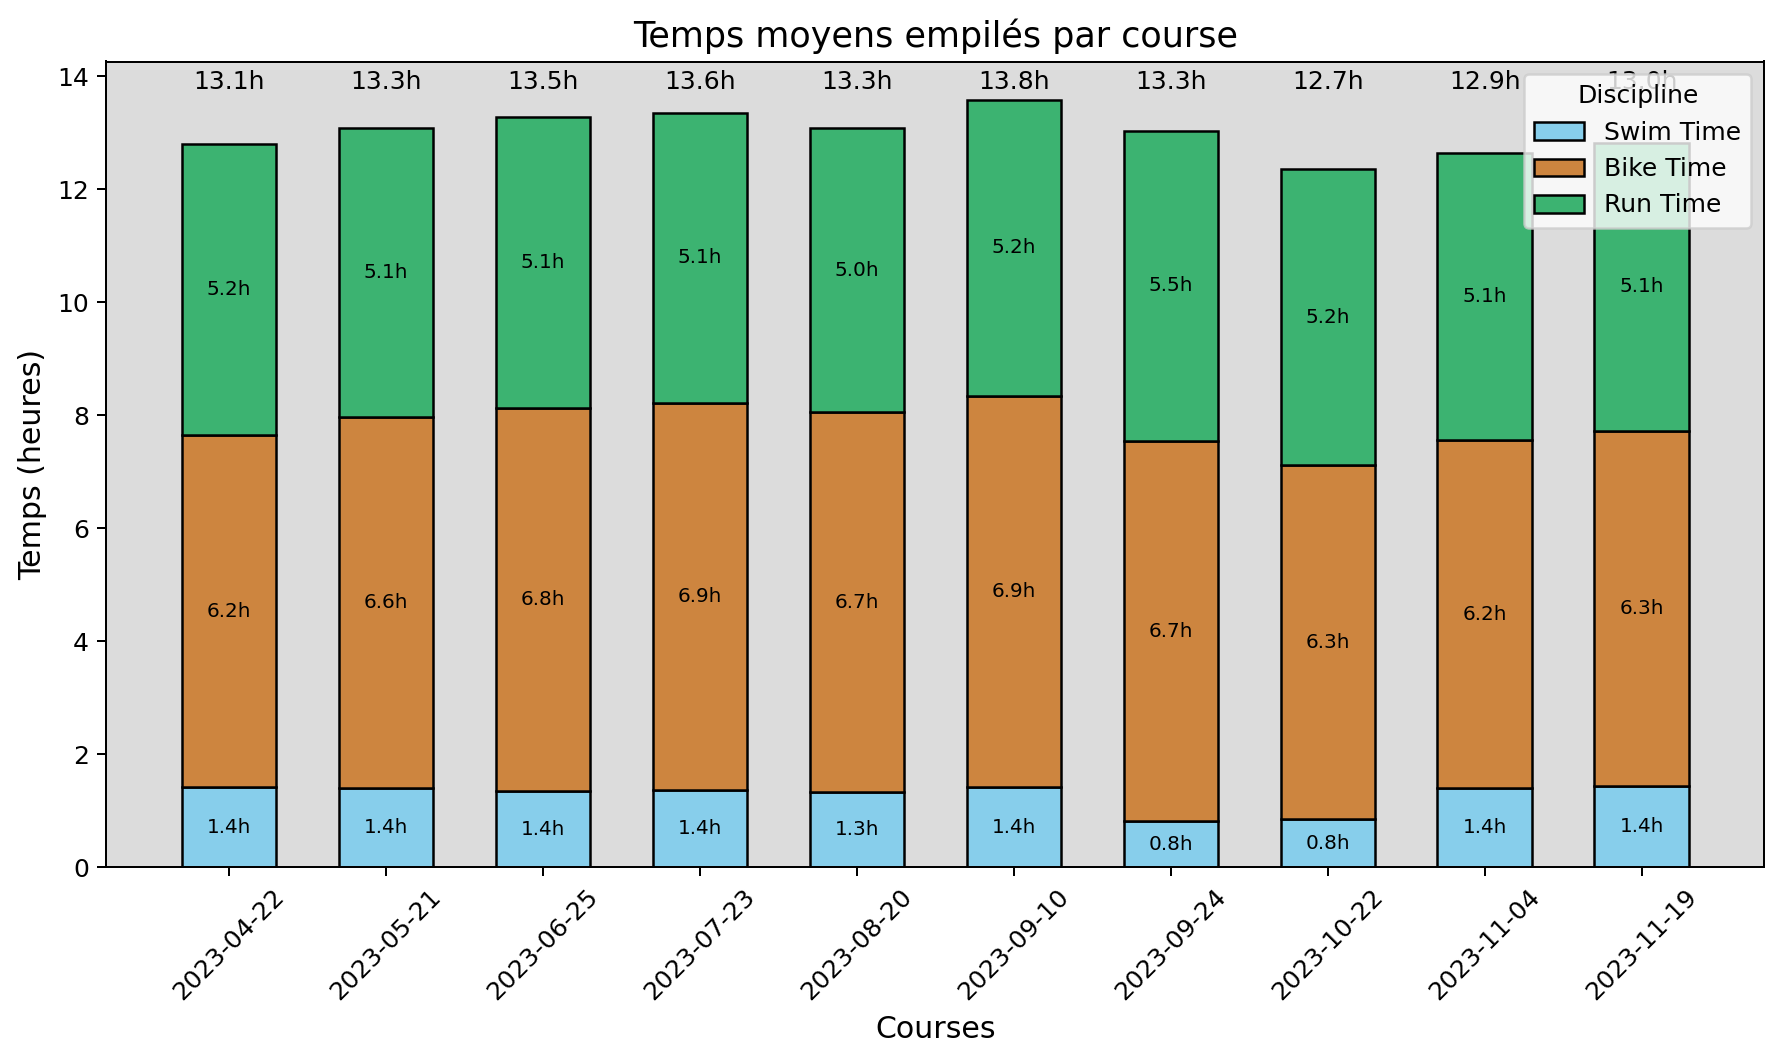

In [12]:

x = np.arange(races_info.shape[0])  # Position des courses
bar_width = 0.6

# Création du stacked bar plot
fig, ax = plt.subplots(dpi=180, figsize=(10, 6))
#ax.grid(True, axis = 'y', zorder=0)
ax.bar(x, races_info['swim_time'], bar_width, label='Swim Time', color='Skyblue', edgecolor = 'k', zorder=1)
ax.bar(x, races_info['bike_time'], bar_width, bottom=races_info['swim_time'], label='Bike Time', color='peru', edgecolor = 'k', zorder=2)
ax.bar(x, races_info['run_time'], bar_width, bottom=races_info['swim_time'] + races_info['bike_time'], label='Run Time', color='mediumseagreen', edgecolor = 'k', zorder=3)
ax.set_facecolor("gainsboro")

for i in range(len(x)):
    ax.text(x[i], races_info['swim_time'][i] / 2, f"{races_info['swim_time'][i]:.1f}h", ha="center", va="center", color="k", fontsize = 8)
    ax.text(x[i], races_info['swim_time'][i] + races_info['bike_time'][i] / 2, f"{races_info['bike_time'][i]:.1f}h", ha="center", va="center", color="k", fontsize = 8)
    ax.text(x[i], races_info['swim_time'][i] + races_info['bike_time'][i] + races_info['run_time'][i] / 2, f"{races_info['run_time'][i]:.1f}h",
             ha="center", va="center", color="k", fontsize = 8)
    ax.text(x[i], 13.9, f"{races_info['overall_time'][i]:.1f}h",
             ha="center", va="center", color="k", fontsize = 10)
    



ax.set_title("Temps moyens empilés par course", fontsize=14)
ax.set_ylabel("Temps (heures)", fontsize=12)
ax.set_xlabel("Courses", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(races_info['Date'], rotation=45, fontsize=10)
ax.legend(title="Discipline", fontsize=10)
#fig.patch.set_facecolor("gainsboro")

plt.tight_layout()

plt.show()

### Intéressons nous au finisher percentage

In [13]:
print("FINISHER PERCENTAGE\n")
[print(f"{races_info.loc[i,'Location']} : {races_info.loc[i,'finisher_perc']:.1f}%") for i in races_info.index]

print(f"\n\nFinsher percentage moy : {races_info['finisher_perc'].mean():.1f}%")

print(f"\n\nFinsher percentage range : from {races_info['finisher_perc'].min():.1f}% to {races_info['finisher_perc'].max():.1f}%")

FINISHER PERCENTAGE

The Woodlands, Texas, USA : 88.3%
Tulsa, Okla., USA : 88.5%
Coeur d’Alene, Idaho, USA : 85.0%
Lake Placid, N.Y., USA : 85.7%
Mont-Tremblant, Quebec, Canada  : 90.7%
Madison, Wisc., USA : 84.9%
Chattanooga, Tenn., USA : 88.9%
Sacramento, Calif., USA : 92.9%
Panama City Beach, Fla., USA : 89.7%
Tempe, Ariz., USA : 88.9%


Finsher percentage moy : 88.4%


Finsher percentage range : from 84.9% to 92.9%


# Répartition Hommes Femmes

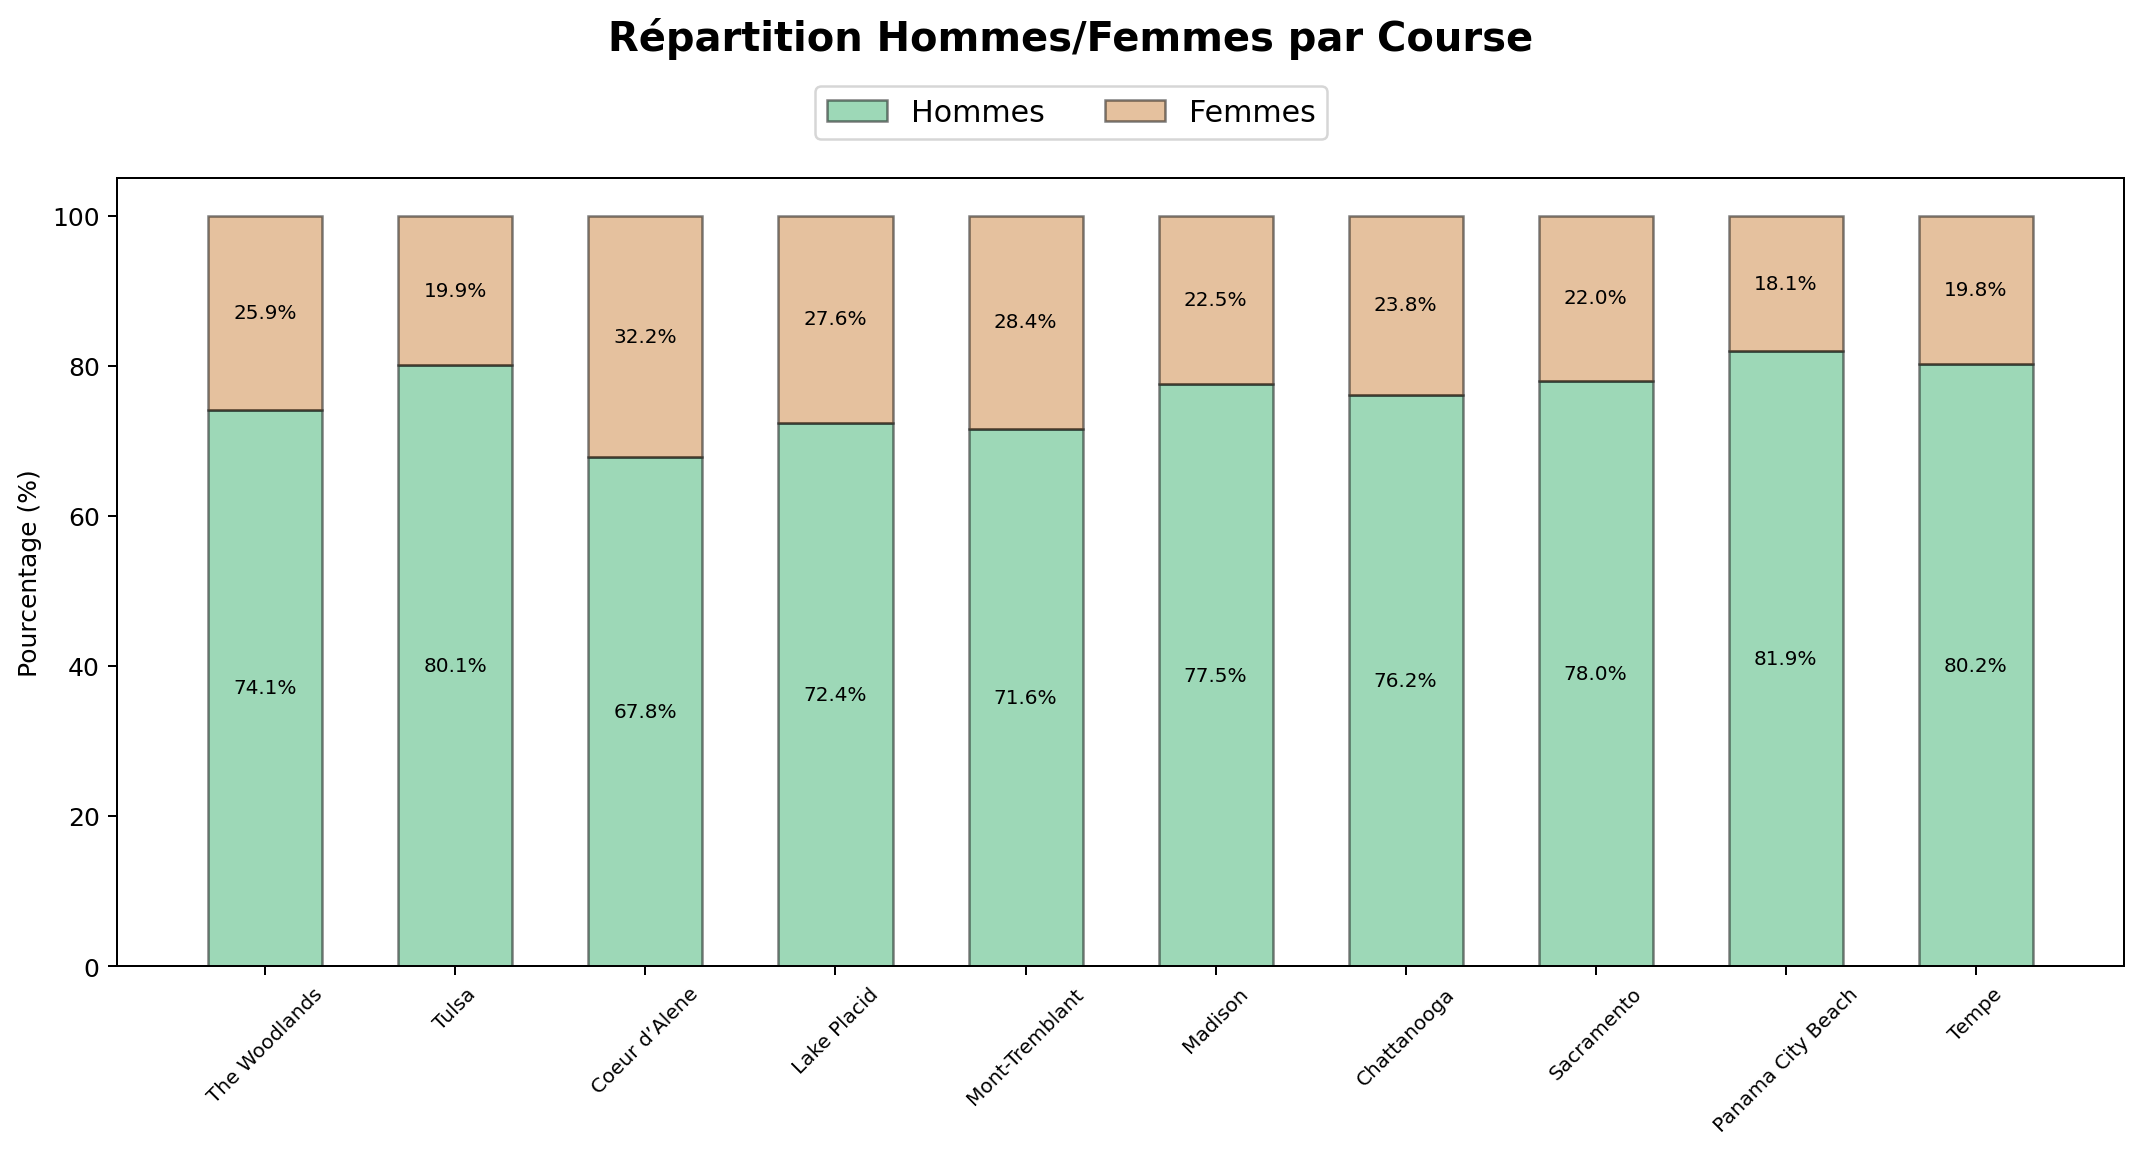

Participation moyenne des femme : 24.0


In [14]:
courses = []
pourcent_hommes = []
pourcent_femmes = []
for race in races_results: 
    result = races_results[race]
    sexe_perc = result['sexe'].value_counts(normalize = True)*100

    courses.append(race.split(",")[0])
    pourcent_hommes.append(sexe_perc.get('Male', 0))  
    pourcent_femmes.append(sexe_perc.get('Female', 0))

x = np.arange(len(courses))  # Positions des barres

# Création du plot
fig, ax = plt.subplots(dpi=180, figsize=(12, 6))

width = 0.6  # Largeur des barres

# Barres empilées
ax.bar(x, pourcent_hommes, width, label="Hommes", color="mediumseagreen",edgecolor="black", alpha = 0.5)
ax.bar(x, pourcent_femmes, width, bottom=pourcent_hommes, label="Femmes", color="peru", edgecolor="black", alpha = 0.5)

# Personnalisation
#ax.set_xlabel("Courses", color="k")
ax.set_ylabel("Pourcentage (%)", color="k")
fig.suptitle("Répartition Hommes/Femmes par Course", color="k",fontsize=16, fontweight='bold',y=1.06)
ax.set_xticks(x)


ax.tick_params(axis="y", labelcolor="k")
ax.set_xticklabels(courses, color="black", fontsize=8, rotation = 45)
# Ajout des annotations (valeurs sur les barres)
for i in range(len(x)):
    ax.text(x[i], pourcent_hommes[i] / 2, f"{pourcent_hommes[i]:.1f}%", ha="center", va="center", color="black", fontsize = 8)
    ax.text(x[i], pourcent_hommes[i] + pourcent_femmes[i] / 2, f"{pourcent_femmes[i]:.1f}%", ha="center", va="center", color="black", fontsize = 8)
handles, labels = ax.get_legend_handles_labels() 
legend = fig.legend(
    handles, labels, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.01)
)
fig.tight_layout()
plt.show()
fig.savefig('Figures/Repartition hommes femmes', bbox_inches='tight', pad_inches=0.1)

print(f"Participation moyenne des femme : {np.mean(pourcent_femmes):.1f}")
    

# Écarts de finish time hommes femmes

In [15]:
# Initialisation des dictionnaires pour stocker les écarts
ecartHF = {"overall_time": {}, "swim_time": {}, "bike_time": {}, "run_time": {}}
interesing_col = ['overall_time', 'swim_time', 'bike_time', 'run_time' ]

# Boucle sur chaque course
for race, result in races_results.items():
    # Calcul des moyennes par sexe pour chaque discipline
    mean_times = result[interesing_col].groupby(result['sexe']).mean()
    
    # Calcul des écarts (en heures) pour chaque discipline
    ecartHF["overall_time"][race] = (mean_times.loc["Female", "overall_time"] - mean_times.loc["Male", "overall_time"]) / 3600
    ecartHF["swim_time"][race] = (mean_times.loc["Female", "swim_time"] - mean_times.loc["Male", "swim_time"]) / 3600
    ecartHF["bike_time"][race] = (mean_times.loc["Female", "bike_time"] - mean_times.loc["Male", "bike_time"]) / 3600
    ecartHF["run_time"][race] = (mean_times.loc["Female", "run_time"] - mean_times.loc["Male", "run_time"]) / 3600

# Conversion des résultats en DataFrame
ecartHF_df = pd.DataFrame({key: pd.Series(value) for key, value in ecartHF.items()})
ecartHF_df.rename(columns={
    "overall_time": "time_sexe_diff",
    "swim_time": "swim_time_sexe_diff",
    "bike_time": "bike_time_sexe_diff",
    "run_time": "run_time_sexe_diff"
}, inplace=True)
#Ajout des nouvelles infos dans le df "races infos"
races_info = pd.merge(races_info, ecartHF_df.reset_index(names = 'Location'), on = 'Location', how = 'inner')


In [16]:
races_info

,Date,Location,GPX file,latitude,longitude,cloud_cover_afternoon,humidity_afternoon,precipitation_total,temperature_min,temperature_max,...,IQR overall_time,IQR time_t1,IQR time_t2,finisher_perc,deniv,alt_moy,time_sexe_diff,swim_time_sexe_diff,bike_time_sexe_diff,run_time_sexe_diff
0,2023-04-22,"The Woodlands, Texas, USA",ironman-texas-2023.gpx,30.168816,-95.475470,0.0,48.0,0.00,13.41,26.44,...,3.222986,0.096528,0.103333,88.349976,574.0,43.0,0.319571,0.016011,0.265810,0.040145
1,2023-05-21,"Tulsa, Okla., USA",ironman-tulsa-2023.gpx,36.135710,-96.276130,0.0,56.0,0.00,11.72,24.85,...,2.660486,0.083056,0.078472,88.536155,1151.0,219.0,0.452342,0.034189,0.446129,0.072774
2,2023-06-25,"Coeur d’Alene, Idaho, USA",ironman-coeur-dalene-2023.gpx,47.673824,-116.790063,0.0,34.0,0.00,11.42,27.27,...,2.754306,0.078194,0.074444,85.025818,2296.0,692.0,-0.064011,-0.011159,0.127349,-0.155729
3,2023-07-23,"Lake Placid, N.Y., USA",ironman-lake-placid-2023.gpx,44.284467,-73.982039,0.0,59.0,0.00,8.86,24.57,...,2.799722,0.081528,0.085069,85.684539,2136.0,434.0,0.110594,0.008681,0.188659,-0.063097
4,2023-08-20,"Mont-Tremblant, Quebec, Canada",ironman-mont-tremblant-2023.gpx,46.208443,-74.595437,40.0,54.0,0.00,10.95,22.98,...,2.549167,0.080556,0.072917,90.681234,2165.0,248.0,0.440097,0.022307,0.334438,0.097715
5,2023-09-10,"Madison, Wisc., USA",ironman-wisconsin-2023.gpx,43.073405,-89.377531,75.0,61.0,0.00,15.15,26.58,...,2.666667,0.083611,0.076944,84.943639,1390.0,288.0,0.686883,0.049276,0.511579,0.179879
6,2023-09-24,"Chattanooga, Tenn., USA",ironman-chattanooga-2023.gpx,35.063108,-85.277487,20.0,51.0,0.00,12.96,28.87,...,2.590833,0.073333,0.087639,88.913043,1305.0,237.0,0.752942,0.033008,0.550896,0.173946
7,2023-10-22,"Sacramento, Calif., USA",ironman-california-2023.gpx,38.601532,-121.485818,100.0,74.0,4.42,13.91,20.47,...,2.877986,0.103819,0.103472,92.932862,437.0,6.0,1.251668,0.047442,0.659249,0.550714
8,2023-11-04,"Panama City Beach, Fla., USA",ironman-florida-2022.gpx,30.214689,-85.877124,0.0,43.0,0.00,11.81,26.26,...,3.150833,0.104167,0.086111,89.744872,315.0,16.0,0.579118,0.070312,0.457134,0.118746
9,2023-11-19,"Tempe, Ariz., USA",ironman-arizona-2022.gpx,33.432250,-111.947100,20.0,56.0,0.00,13.81,21.84,...,2.838333,0.094167,0.071667,88.944724,771.0,367.0,0.794482,0.052807,0.478628,0.275073


On a étonnamment une course où les femmes ont été plus rapides que les hommes 

Temps moy femmes : 

Sacramento : 13.707321696696695
Idaho : 13.434931650893795


Temps moy hommes : 

Sacramento : 12.45565327978581
Idaho : 13.498942705745984


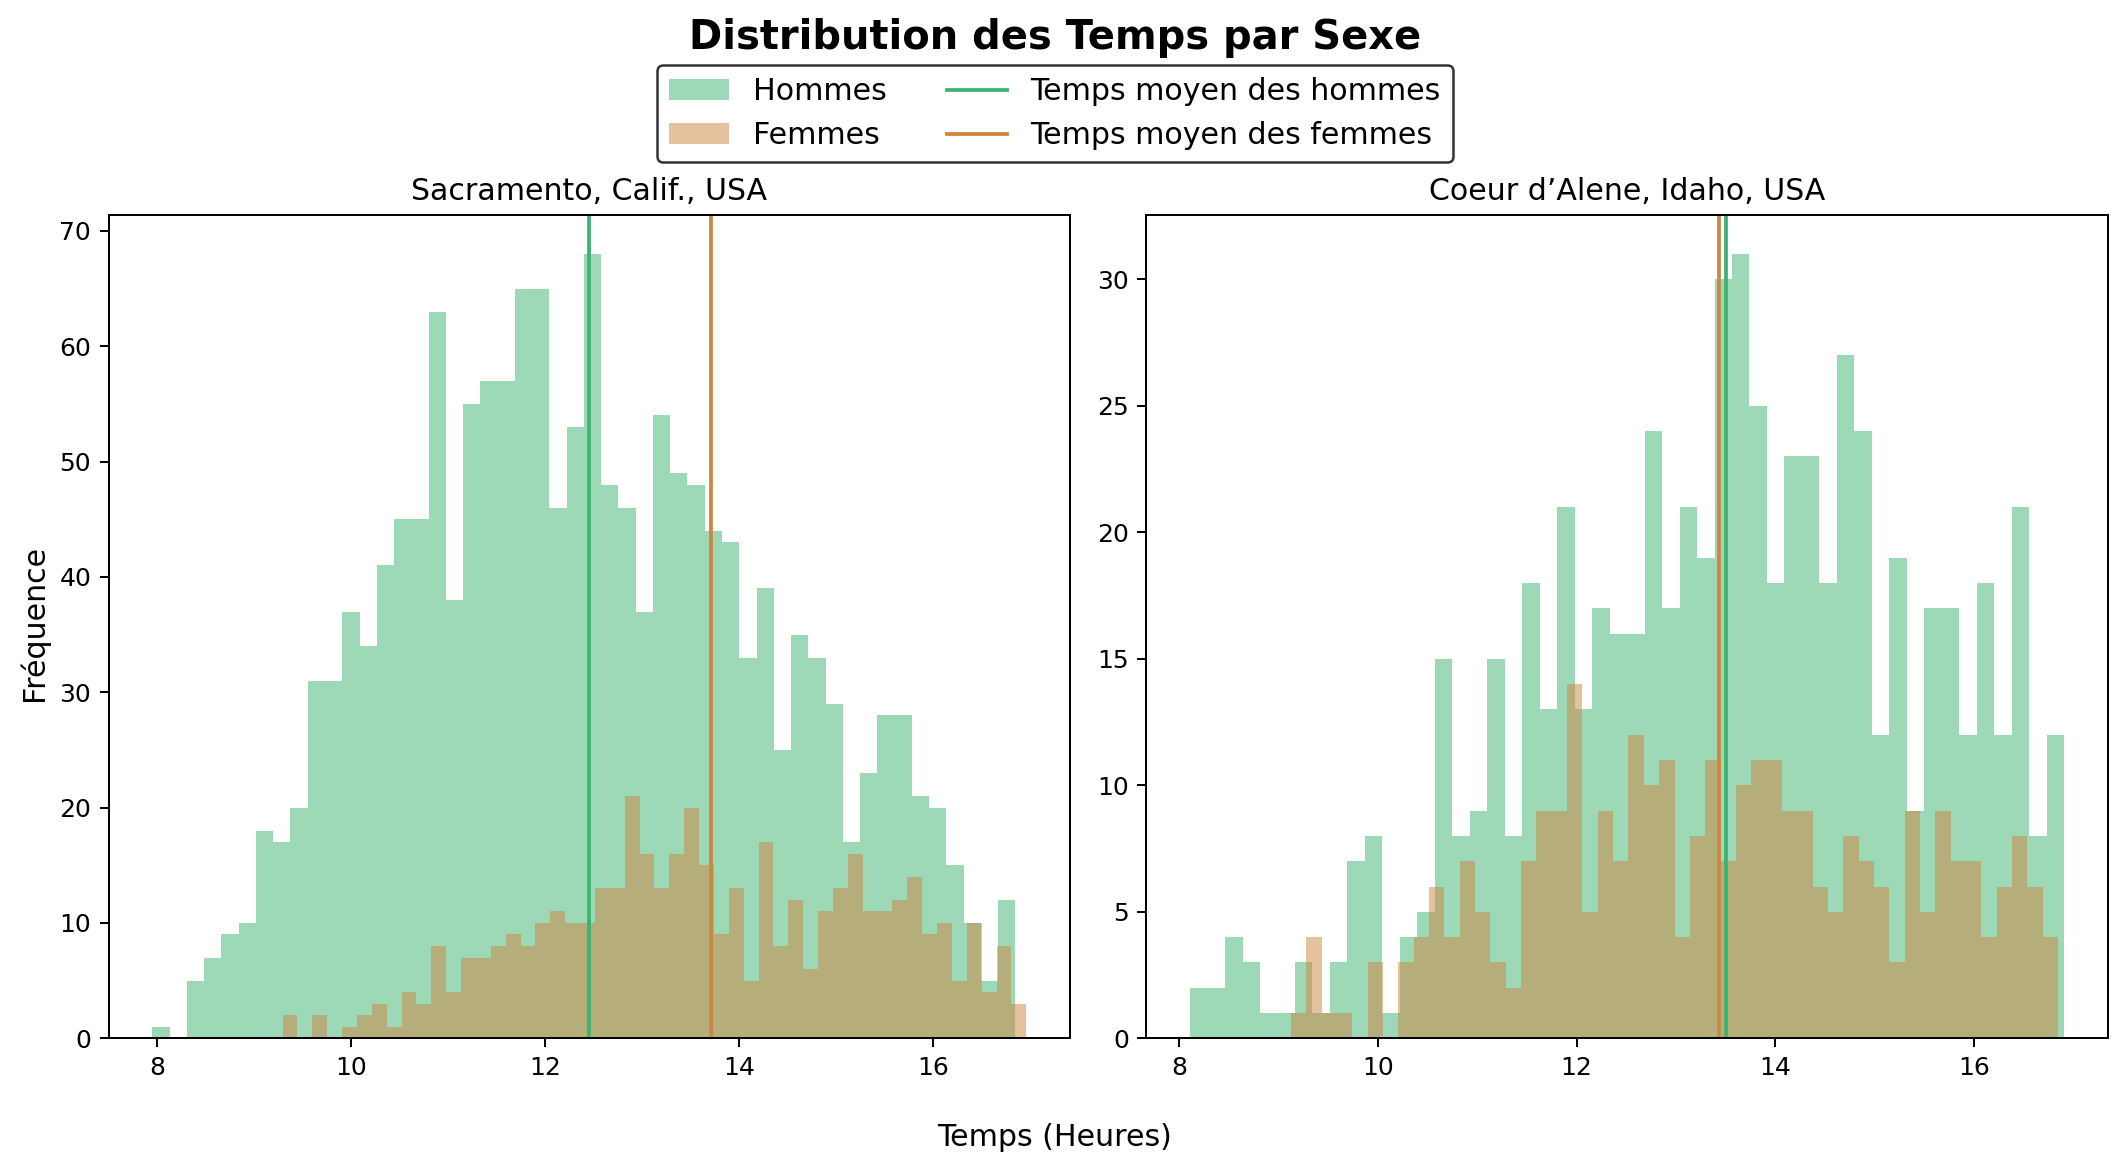

In [17]:
# plt.close('all')
race_diff_max = races_results[ecartHF_df['time_sexe_diff'].idxmax()]
race_diff_min = races_results[ecartHF_df['time_sexe_diff'].idxmin()]

# Séparation les données par sexe

max_hommes = race_diff_max[race_diff_max['sexe'] == 'Male']['overall_time'] / 3600 # pour avoir le temps en heure (plus lisible sur le graph)
max_femmes = race_diff_max[race_diff_max['sexe'] == 'Female']['overall_time'] / 3600

min_hommes = race_diff_min[race_diff_min['sexe'] == 'Male']['overall_time'] / 3600
min_femmes = race_diff_min[race_diff_min['sexe'] == 'Female']['overall_time'] / 3600


fig, ax = plt.subplots(1, 2, dpi=180, figsize=(12, 6))

# Création des plots
ax[0].hist(max_hommes, bins=50, alpha=0.5, label='Hommes', color='mediumseagreen')
ax[0].hist(max_femmes, bins=50, alpha=0.5, label='Femmes', color='peru')

ax[0].axvline(max_hommes.mean(), color = 'mediumseagreen', label = 'Temps moyen des hommes')
ax[0].axvline(max_femmes.mean(), color = 'peru', label = 'Temps moyen des femmes')

ax[1].hist(min_hommes, bins=50, alpha=0.5, label='Hommes', color='mediumseagreen')
ax[1].hist(min_femmes, bins=50, alpha=0.5, label='Femmes', color='peru')

ax[1].axvline(min_hommes.mean(), color = 'mediumseagreen', label = 'Temps moyen des hommes')
ax[1].axvline(min_femmes.mean(), color = 'peru', label = 'Temps moyen des femmes')

print(f"Temps moy femmes : \n\nSacramento : {max_femmes.mean()}\nIdaho : {min_femmes.mean()}")

print(f"\n\nTemps moy hommes : \n\nSacramento : {max_hommes.mean()}\nIdaho : {min_hommes.mean()}")

ax[0].set_title(ecartHF_df['time_sexe_diff'].idxmax())
ax[1].set_title(ecartHF_df['time_sexe_diff'].idxmin())



# Titre, labels et légende globaux
fig.suptitle("Distribution des Temps par Sexe", fontsize=16, fontweight='bold', y=1.06)  # Titre global
fig.supxlabel("Temps (Heures)", fontsize=12)  # Label global pour l'axe X
fig.supylabel("Fréquence", fontsize=12)  # Label global pour l'axe Y

# Ajout d'une légende globale
handles, labels = ax[0].get_legend_handles_labels() 
legend = fig.legend(
    handles, labels, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.03)
)

legend.get_frame().set_edgecolor("black")  


fig.subplots_adjust(top=0.85)
fig.tight_layout() 


fig.savefig("Figures/Distrib_HF", bbox_inches='tight', pad_inches=0.1)

plt.show()




### On se demande pour quelle catégorie les femmes ont été plus rapides que les hommes et si les femmes sont surreprésentées dans les catégories les plus rapides, ce qui pourrait expliquer que leur temps moyen soit plus faible que celui des hommes.

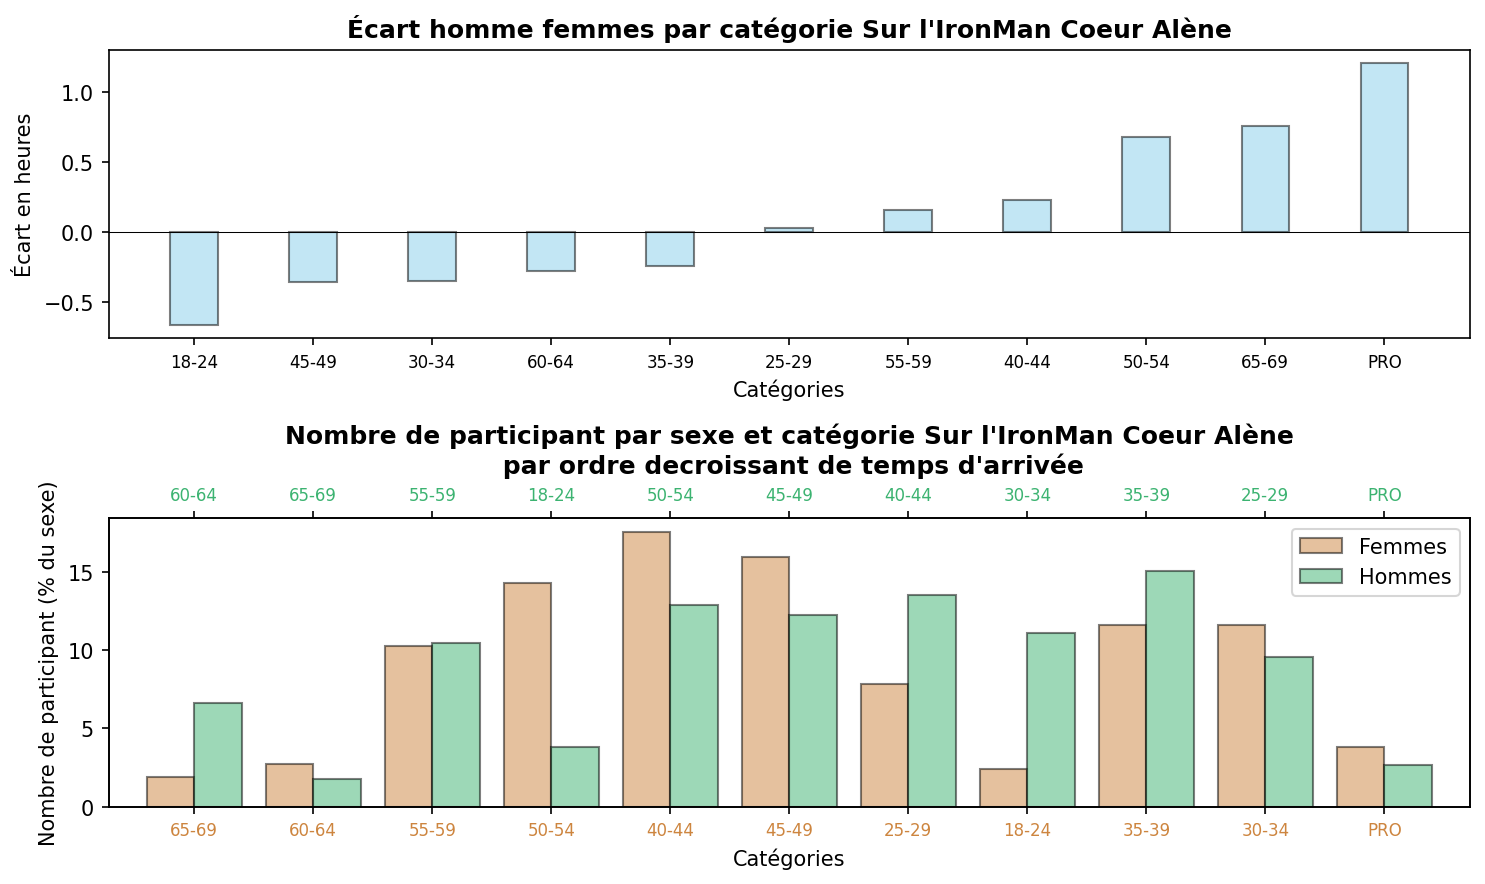

In [18]:
min_cat = race_diff_min['overall_time'].groupby(race_diff_min['division']).mean()
hommes = min_cat[min_cat.index.str.startswith('M')]
femmes = min_cat[min_cat.index.str.startswith('F')]
# Identification les catégories communes
categories_hommes = hommes.index.str[1:]  
categories_femmes = femmes.index.str[1:]  

categories_communes = categories_hommes.intersection(categories_femmes)

# Filtrage pour ne garder que les catégories communes
hommes_communs = hommes[hommes.index.str[1:].isin(categories_communes)]
femmes_communes = femmes[femmes.index.str[1:].isin(categories_communes)]
# Calcul de l'écart entre les sexes
ecarts = femmes_communes.values - hommes_communs.values

# Résultat sous forme de DataFrame pour plus de clarté
resultat = pd.DataFrame({
    'categorie_age': hommes_communs.index.str[1:],
    'ecart_temps': ecarts
})

# Extraction les catégories d'âge en ignorant le sexe (M18-24 -> 18-24)
race_diff_min['age_category'] = race_diff_min['division'].str[1:]

# Compter le nombre de participants par catégorie d'âge
participant_count = pd.DataFrame(race_diff_min.groupby(['age_category', 'sexe']).size())
participant_count = participant_count.reset_index()

participant_count_f = participant_count[participant_count['sexe'] == 'Female']
participant_count_m = participant_count[participant_count['sexe'] == 'Male']
participant_count_m.columns = ['categorie_age', 'sexe', 'nb_male']
participant_count_f.columns = ['categorie_age', 'sexe', 'nb_female']
index1 = femmes_communes.sort_values(ascending=False).index
index1 = [indexes[1:] for indexes in index1]
participant_count_f = participant_count_f.set_index('categorie_age').loc[index1].reset_index(names = 'categorie_age')

index2 = hommes_communs.sort_values(ascending=False).index
index2 = [indexes[1:] for indexes in index2]
participant_count_m = participant_count_m.set_index('categorie_age').loc[index2].reset_index(names = 'categorie_age')

participant_count_f['nb_female_perc'] = participant_count_f['nb_female'] / participant_count_f['nb_female'].sum()*100
participant_count_m['nb_male_perc'] = participant_count_m['nb_male'] / participant_count_m['nb_male'].sum()*100


resultat = pd.merge(resultat, participant_count_f, on = 'categorie_age', how = 'inner')
resultat = pd.merge(resultat, participant_count_m, on = 'categorie_age', how = 'inner')
resultat = resultat.sort_values('ecart_temps')


x = np.arange(resultat.shape[0])
# Création du plot
fig, ax = plt.subplots(2,1, dpi=150, figsize=(10, 6))
width = 0.4  # Largeur des barres


ax[0].bar(x, resultat["ecart_temps"]/3600, width, color='skyblue',edgecolor="black", alpha = 0.5)
ax[0].axhline(0, color = 'black', linewidth = 0.5)



ax[0].set_xlabel("Catégories", color="k")
ax[0].set_ylabel("Écart en heures", color="k")
ax[0].set_title("Écart homme femmes par catégorie Sur l'IronMan Coeur Alène", color="k", fontweight='bold')
ax[0].set_xticks(x)
ax[0].set_xticklabels(resultat['categorie_age'], color="k", fontsize=8)

ax[0].tick_params(axis="y", labelcolor="k")


ax2 = ax[1].twiny()
ax[1].bar(x - width/2, participant_count_f['nb_female_perc'], width, color = 'peru', edgecolor = 'black', alpha = 0.5, label = 'Femmes')
ax[1].bar(x + width/2, participant_count_m['nb_male_perc'], width, color = 'mediumseagreen', edgecolor = 'black', alpha = 0.5, label = 'Hommes')
ax[1].set_xlabel("Catégories", color="k")
ax[1].set_ylabel("Nombre de participant (% du sexe)", color="k")
ax[1].set_title("Nombre de participant par sexe et catégorie Sur l'IronMan Coeur Alène\n par ordre decroissant de temps d'arrivée", color="k", fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels(index1, color="peru", fontsize=8)
ax2.set_xticks(x)
ax2.set_xticklabels(index2, color="mediumseagreen", fontsize=8)
ax[1].set_xlim(ax[0].get_xlim()) 
ax2.set_xlim(ax[1].get_xlim()) 


ax[1].legend()
fig.tight_layout()
plt.savefig('Figures/sexe_categorie')


### Dans la catégorie pro ce sont les homme qui gagne et avec l'écart le plus important de toutes les catégories

### On aurait pu penser à un paradoxe de Simpson pour les résultats de la course à Cœur d'Alène, c'est-à-dire que les femmes étaient surreprésentées dans les catégories où elles sont les plus rapides. Mais ce n'est pas le cas : les distributions d'hommes et de femmes par catégorie sont sensiblement identiques, et il n'y a pas significativement plus de femmes dans les catégories les plus rapides.

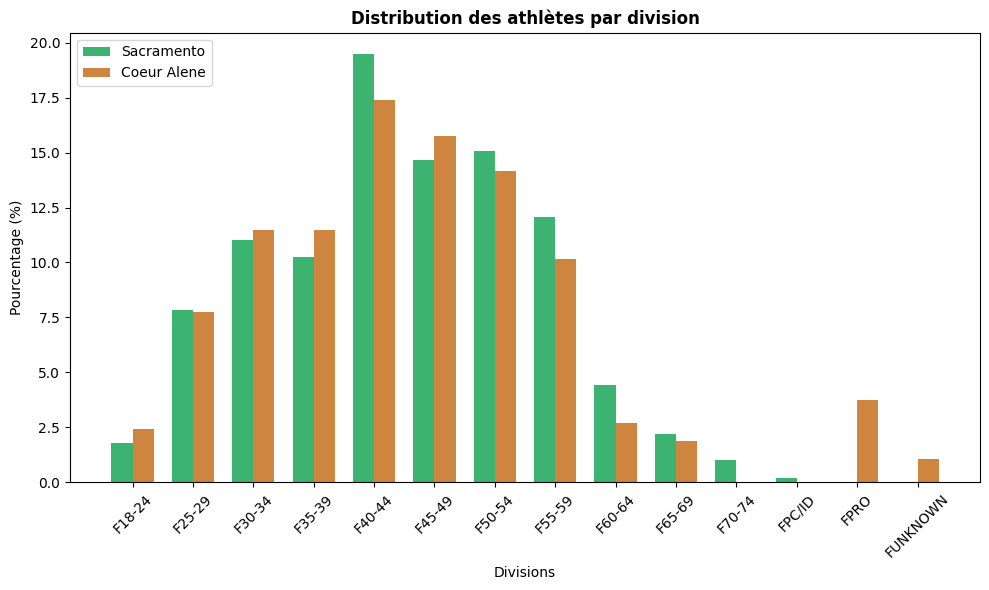

In [19]:
filtered_data_min = race_diff_min[race_diff_min['sexe'] == 'Female']
filtered_data_max = race_diff_max[race_diff_max['sexe'] == 'Female']

perc_div_min = filtered_data_min['division'].value_counts(normalize = True)*100
perc_div_max = filtered_data_max['division'].value_counts(normalize = True)*100
perc_div_min
merge = pd.merge(perc_div_max.to_frame(), perc_div_min.to_frame(), left_index=True, right_index=True, how = 'outer')
merge.columns = ['Sacramento', 'Coeur Alene']
merge.sort_index()

x = np.arange(len(merge.index))
width = 0.35

# Création de la figure
fig, ax = plt.subplots(figsize=(10, 6))
# Ajout des barres pour chaque course
bar1 = ax.bar(x - width/2, merge['Sacramento'], width, label='Sacramento', color='mediumseagreen')
bar2 = ax.bar(x + width/2, merge['Coeur Alene'], width, label='Coeur Alene', color='peru')

# Personnalisation
ax.set_xlabel('Divisions')
ax.set_ylabel('Pourcentage (%)')
ax.set_title('Distribution des athlètes par division', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(merge.index, rotation=45)
ax.legend()

plt.tight_layout()



### La distribution des femmes dans les différentes catégories est sensiblement la même pour Sacramento et Cœur d'Alène. On remarque cependant qu'il n'y avait pas de pro à Sacramento.

In [20]:
#Création de colonne d'ecart en pourcentage du temps moyen de la course qu'on ajoute au df races infos
columns1 = ['time_sexe_diff', 'swim_time_sexe_diff', 'bike_time_sexe_diff', 'run_time_sexe_diff']
columns2 = ['overall_time', 'swim_time', 'bike_time', 'run_time']

for col1, col2 in zip(columns1,columns2):    
    races_info[f'{col1}_perc'] = races_info[col1] / races_info[col2] * 100



In [21]:
pd.set_option("Display.max_columns", None)
races_info

,Date,Location,GPX file,latitude,longitude,cloud_cover_afternoon,humidity_afternoon,precipitation_total,temperature_min,temperature_max,pressure_afternoon,wind_speed_max,wind_direction_max,swim_time,bike_time,run_time,overall_time,time_t1,time_t2,overall_time_female,overall_time_male,swim_time 25%,bike_time 25%,run_time 25%,overall_time 25%,time_t1 25%,time_t2 25%,swim_time 75%,bike_time 75%,run_time 75%,overall_time 75%,time_t1 75%,time_t2 75%,IQR swim_time,IQR bike_time,IQR run_time,IQR overall_time,IQR time_t1,IQR time_t2,finisher_perc,deniv,alt_moy,time_sexe_diff,swim_time_sexe_diff,bike_time_sexe_diff,run_time_sexe_diff,time_sexe_diff_perc,swim_time_sexe_diff_perc,bike_time_sexe_diff_perc,run_time_sexe_diff_perc
0,2023-04-22,"The Woodlands, Texas, USA",ironman-texas-2023.gpx,30.168816,-95.475470,0.0,48.0,0.00,13.41,26.44,1014.0,4.63,110.0,1.417401,6.228512,5.156855,13.091159,0.160173,0.1747,47983.894958,46833.437771,1.215208,5.580903,4.324444,11.518611,0.104097,0.115139,1.576528,6.858542,6.010417,14.741597,0.200625,0.218472,0.361319,1.277639,1.685972,3.222986,0.096528,0.103333,88.349976,574.0,43.0,0.319571,0.016011,0.265810,0.040145,2.441124,1.129575,4.267625,0.778487
1,2023-05-21,"Tulsa, Okla., USA",ironman-tulsa-2023.gpx,36.135710,-96.276130,0.0,56.0,0.00,11.72,24.85,1022.0,2.12,64.0,1.410793,6.551783,5.114415,13.279097,0.151801,0.120354,49118.525773,47490.093827,1.235972,5.886944,4.381806,11.985694,0.105,0.0725,1.539444,7.159028,5.816667,14.646181,0.188056,0.150972,0.303472,1.272083,1.434861,2.660486,0.083056,0.078472,88.536155,1151.0,219.0,0.452342,0.034189,0.446129,0.072774,3.406423,2.423387,6.809279,1.422918
2,2023-06-25,"Coeur d’Alene, Idaho, USA",ironman-coeur-dalene-2023.gpx,47.673824,-116.790063,0.0,34.0,0.00,11.42,27.27,1017.0,3.60,190.0,1.354372,6.780958,5.135673,13.478405,0.136966,0.138239,48365.753943,48596.193741,1.189722,6.172986,4.418333,12.107917,0.092222,0.0925,1.486944,7.407708,5.856944,14.862222,0.170417,0.166944,0.297222,1.234722,1.438611,2.754306,0.078194,0.074444,85.025818,2296.0,692.0,-0.064011,-0.011159,0.127349,-0.155729,-0.474916,-0.823905,1.878032,-3.032307
3,2023-07-23,"Lake Placid, N.Y., USA",ironman-lake-placid-2023.gpx,44.284467,-73.982039,0.0,59.0,0.00,8.86,24.57,1019.0,3.83,275.0,1.365537,6.855918,5.128187,13.584402,0.176867,0.145585,49194.587838,48796.450915,1.211944,6.2425,4.436944,12.247847,0.128889,0.096389,1.498472,7.507778,5.882778,15.047569,0.210417,0.181458,0.286528,1.265278,1.445833,2.799722,0.081528,0.085069,85.684539,2136.0,434.0,0.110594,0.008681,0.188659,-0.063097,0.814122,0.635712,2.751766,-1.230403
4,2023-08-20,"Mont-Tremblant, Quebec, Canada",ironman-mont-tremblant-2023.gpx,46.208443,-74.595437,40.0,54.0,0.00,10.95,22.98,1013.0,4.99,243.0,1.334069,6.716441,5.031132,13.336362,0.170295,0.135031,49150.603535,47566.253202,1.183611,6.129444,4.358889,12.101806,0.125694,0.093194,1.456389,7.272222,5.683056,14.650972,0.20625,0.166111,0.272778,1.142778,1.324167,2.549167,0.080556,0.072917,90.681234,2165.0,248.0,0.440097,0.022307,0.334438,0.097715,3.29998,1.6721,4.979397,1.942198
5,2023-09-10,"Madison, Wisc., USA",ironman-wisconsin-2023.gpx,43.073405,-89.377531,75.0,61.0,0.00,15.15,26.58,1020.0,5.14,360.0,1.414165,6.930288,5.233823,13.823669,0.190509,0.136485,51687.178723,49214.40122,1.243611,6.342639,4.58875,12.578194,0.143611,0.091389,1.551181,7.488958,5.920903,15.244861,0.227222,0.168333,0.307569,1.146319,1.332153,2.666667,0.083611,0.076944,84.943639,1390.0,288.0,0.686883,0.049276,0.511579,0.179879,4.968888,3.484456,7.38179,3.436865
6,2023-09-24,"Chattanooga, Tenn., USA",ironman-chattanooga-2023.gpx,35.063108,-85.277487,20.0,51.0,0.00,12.96,28.87,1015.0,3.58,80.0,0.812778,6.734507,5.482604,13.267098,0.158346,0.158631,49853.589286,47142.997888,0.749444,6.1225,4.787222,12.0175,0.116944,0.105,0.868889,7.315417,6.212917,14.608333,0.190278,0.192639,0.119444,1.192917,1.425694,2.590833,0.073333,0.087639,88.913043,1305.0,237.0,0.752942,0.033008,0.550896,0.173946,5.675258,4.061101,8.180201

### On s'intéresse maintenant au dénivelé des courses

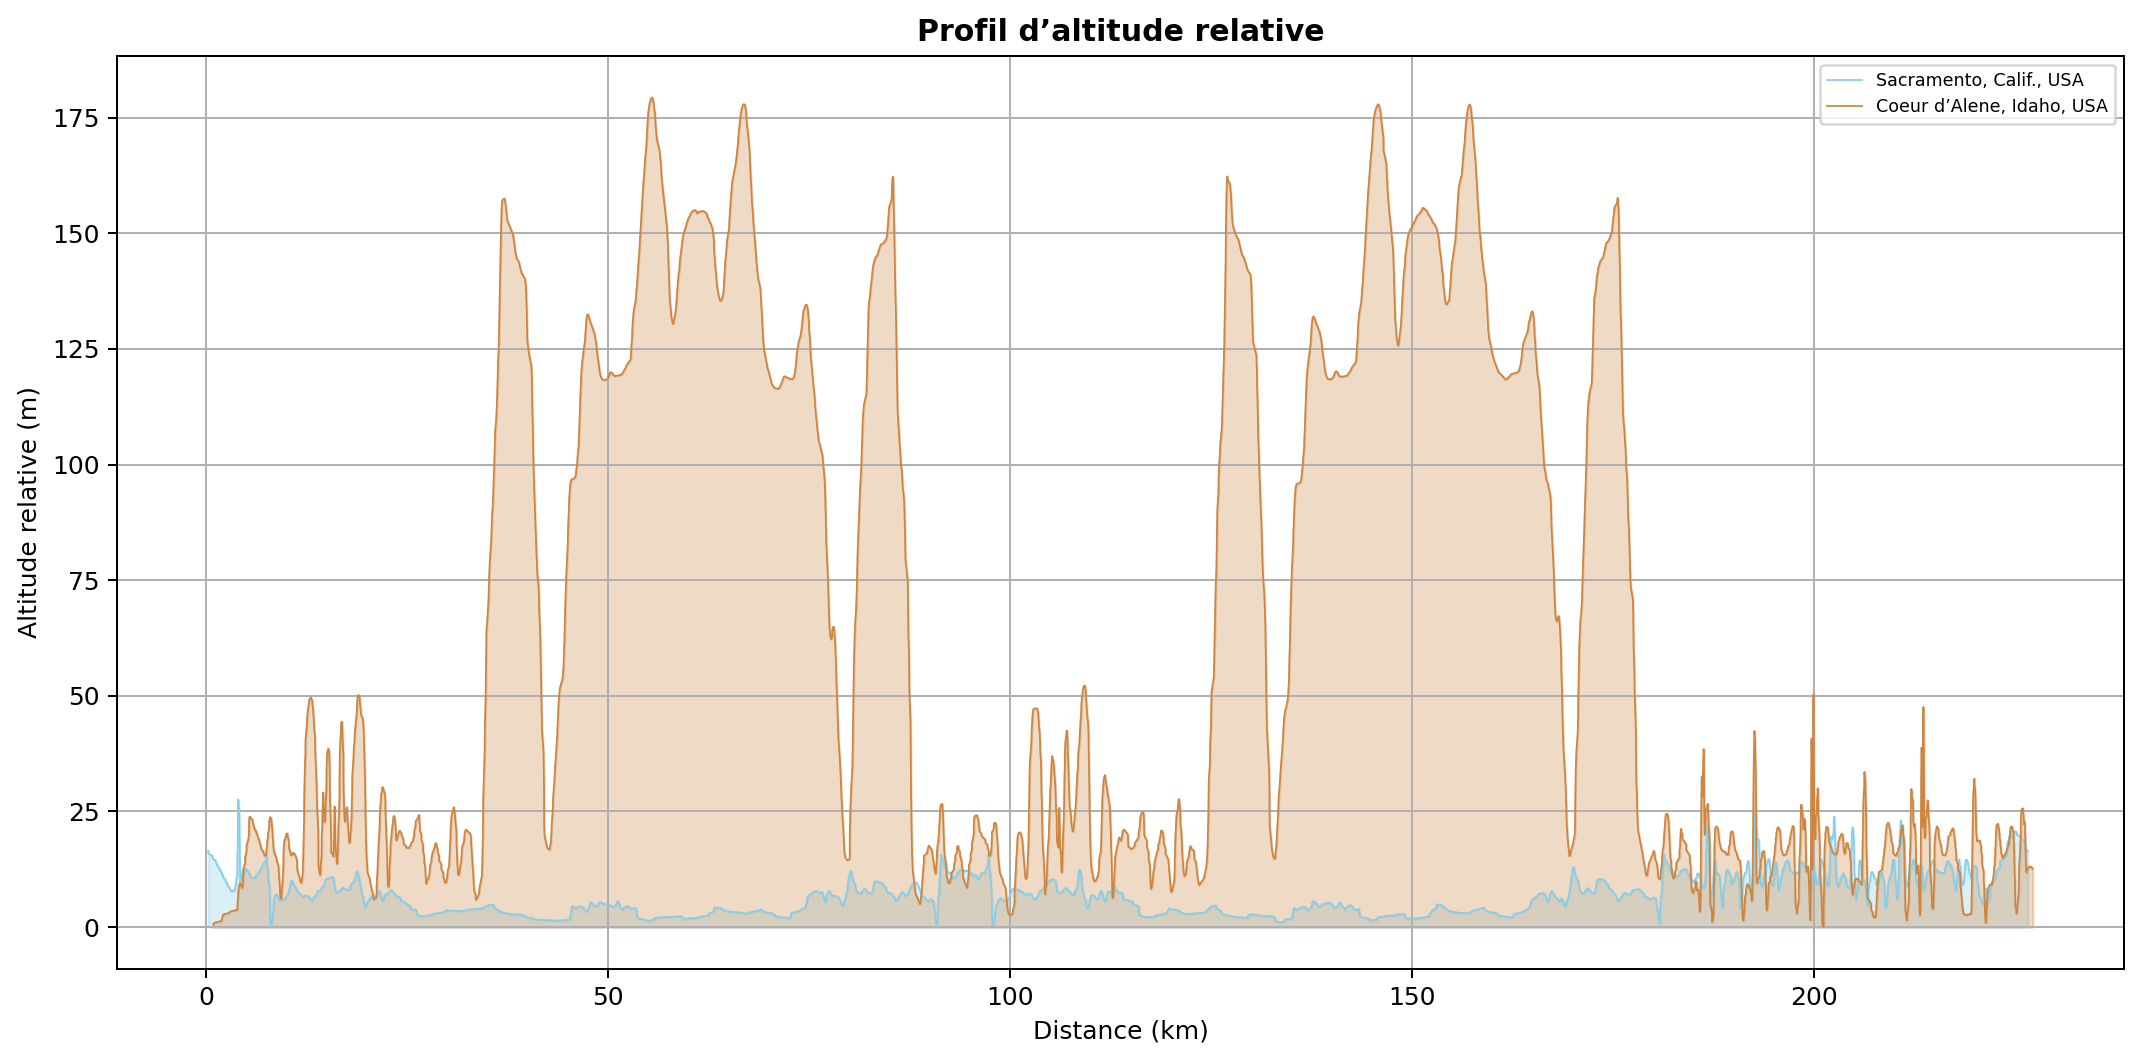

In [22]:
deniv_max = races_info['Location'][races_info['time_sexe_diff'].idxmax()]
deniv_min = races_info['Location'][races_info['time_sexe_diff'].idxmin()]

# Création de la figure et des axes
fig, ax = plt.subplots(dpi=180, figsize = (12,6))

# Tracé pour deniv_max
ax.plot(gpx_data[deniv_max]['Distance'], 
        gpx_data[deniv_max]['filt_alt'] - gpx_data[deniv_max]['filt_alt'].min(), 
        linewidth=0.7, color='skyblue', 
        label = deniv_max )
ax.fill_between(gpx_data[deniv_max]['Distance'], 
                gpx_data[deniv_max]['filt_alt'] - gpx_data[deniv_max]['filt_alt'].min(), 
                alpha=0.3, color='skyblue')

# Tracé pour deniv_min
ax.plot(gpx_data[deniv_min]['Distance'], 
        gpx_data[deniv_min]['filt_alt'] - gpx_data[deniv_min]['filt_alt'].min(), 
        linewidth=0.7, color='peru',
        label = deniv_min)
ax.fill_between(gpx_data[deniv_min]['Distance'], 
                gpx_data[deniv_min]['filt_alt'] - gpx_data[deniv_min]['filt_alt'].min(), 
                alpha=0.3, color='peru')

# Ajout des étiquettes et d'autres personnalisations si nécessaire
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Altitude relative (m)')
ax.set_title('Profil d’altitude relative', fontweight='bold')
ax.legend(fontsize = 7)
fig.tight_layout()
fig.savefig('Figures/Profil altitude')
ax.grid(True)


### Il semblerait que la course où les femmes ont été meilleures que les hommes en moyenne soit celle présentant le plus de dénivelé. Ce paramètre a-t-il un impact récurrent sur les écarts hommes/femmes ?

# Étude des coorélations

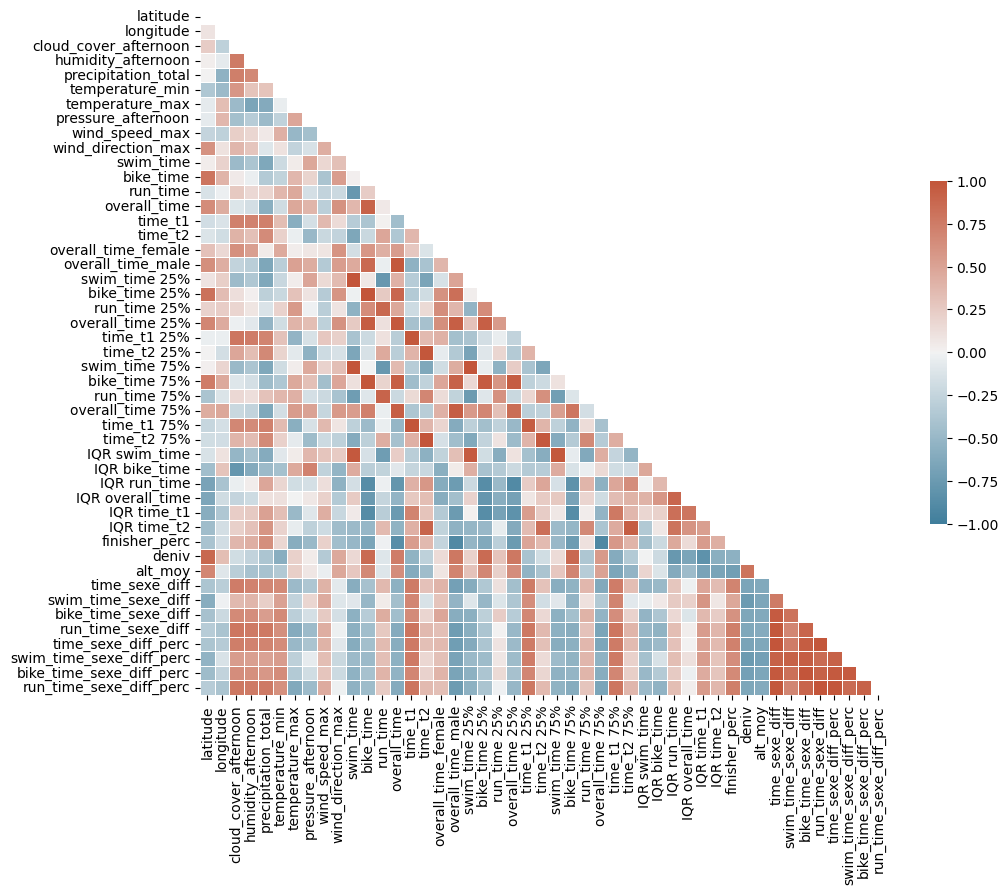

In [23]:
corr = races_info.select_dtypes(include=[np.number]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#plt.figure(dpi = 180)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()


### Beacoup trop de variables ici, ce n'est pas très lisible, on va se concentrer sur les corrélations les plus fortes : valeur absolue > 0.7

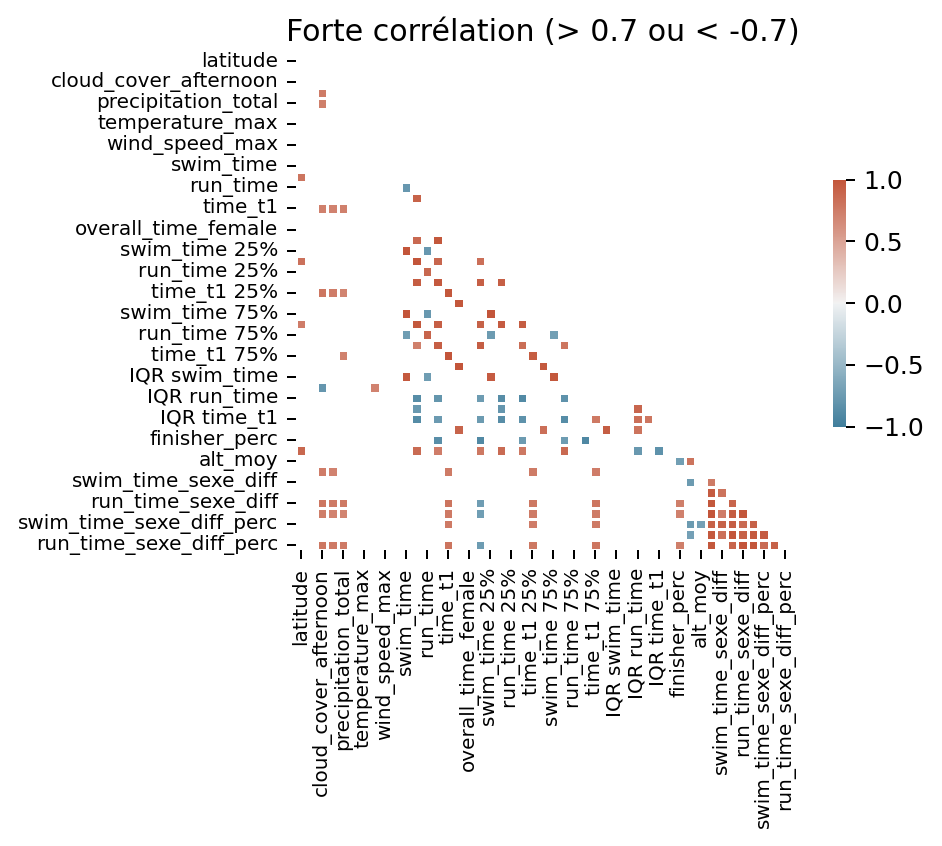

In [24]:
# Création d'un masque pour masquer les valeurs en dehors de [-0.7, 0.7]
mask = np.zeros_like(corr, dtype=bool)
mask[(corr > -0.7) & (corr < 0.7)] = True 
mask = mask | np.triu(np.ones_like(mask, dtype=bool))

# On fait un nouveau plot de la heatmap uniquement avec les corrélation forte 
fig, ax = plt.subplots(dpi = 180)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Forte corrélation (> 0.7 ou < -0.7)")
ax.tick_params(axis='x', labelsize=8)  # Axe X
ax.tick_params(axis='y', labelsize=8)
fig.tight_layout()



### Mieux mais il y a encore beaucoup de variables qui ne sont pas très utiles : swim_time et swim_time_25% par exemple. Les deux diagonales qu'on voit généralement sont simplement des variables redondante

### Ici on va chercher les corrélations spécifiquement entre le dénivelé, la météo et nos variables de temps de course

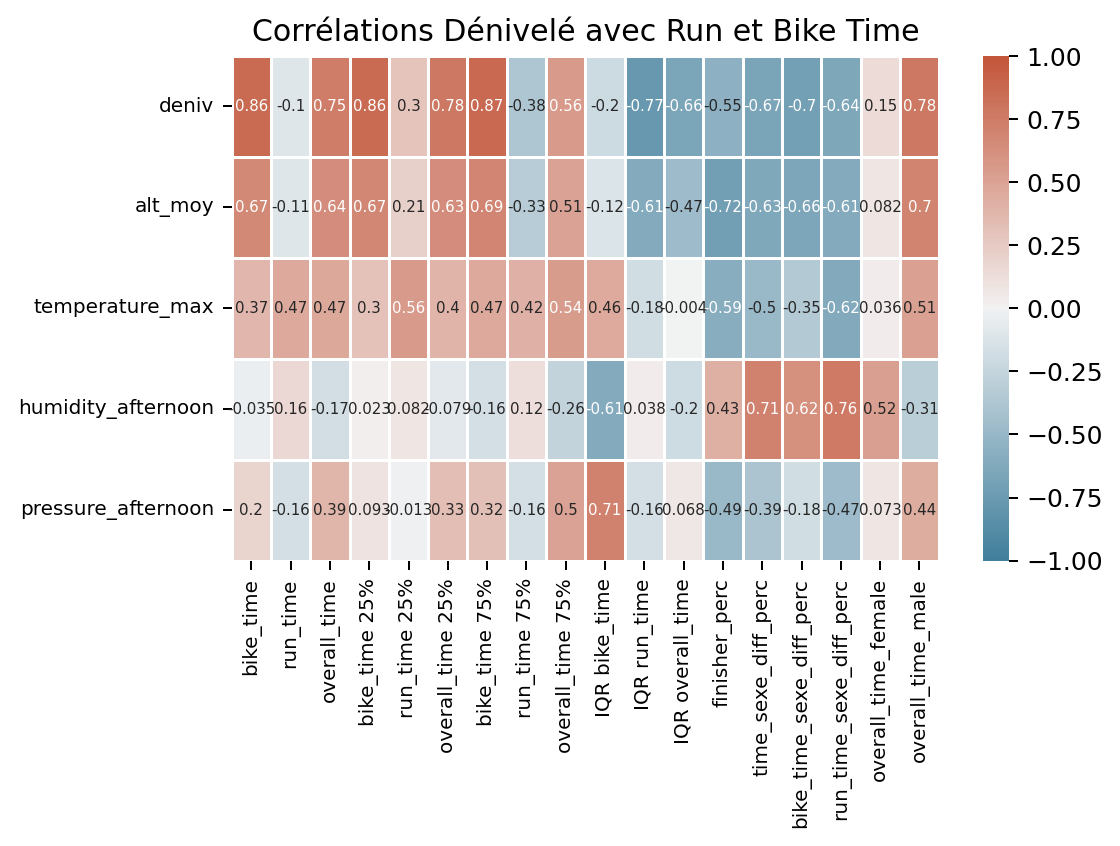

In [25]:
target = ['deniv', 'alt_moy', 'temperature_max', 'humidity_afternoon', 'pressure_afternoon']
related_columns = ['bike_time', 'run_time', 'overall_time', 'bike_time 25%', 'run_time 25%', 'overall_time 25%','bike_time 75%', 'run_time 75%',
 'overall_time 75%', 'IQR bike_time', 'IQR run_time', 'IQR overall_time', 'finisher_perc', 'time_sexe_diff_perc', 'bike_time_sexe_diff_perc', "run_time_sexe_diff_perc", 'overall_time_female', 'overall_time_male']
filtered_corr = corr.loc[target, related_columns]
# Plot de la heatmap
plt.figure(dpi = 180)
sns.heatmap(filtered_corr, annot=True, cmap=cmap, center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 6})
plt.xticks(fontsize=8, rotation = 90)  
plt.yticks(fontsize=8)
plt.title("Corrélations Dénivelé avec Run et Bike Time")
plt.tight_layout()
plt.show()

### Beaucoup plus lisible: on peut voir que le dénivelé est une variable qui impacte beaucoup les performances : 
### Généralement corrélé positivement avec les temps de course (sauf la course à pied) mais corrélé négativement avec les IQR et écart hommes femmes
### L'humidité en revanche n'est pas beaucoup corrélé avec les temps de courses mais beaucoup avec les écart hommes femmes

In [26]:
# On cherche le top 10 des corrélations
corr_pairs = (
    filtered_corr
    .abs()  # On prend la valeur absolue
    .unstack()  # Déplie la matrice
    .reset_index()  # Transforme en DataFrame
    .rename(columns={0: 'Correlation', 'level_0': 'Variable 1', 'level_1': 'Variable 2'})
)

# Filtrage des doublons et corrélations de soi-même
corr_pairs = corr_pairs[corr_pairs['Variable 1'] != corr_pairs['Variable 2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])

# Récupérer les 10 plus fortes corrélations
top_10_corr = corr_pairs.nlargest(10, 'Correlation')

# Affichage
print(top_10_corr)

                 Variable 1          Variable 2  Correlation
30            bike_time 75%               deniv     0.867769
0                 bike_time               deniv     0.858930
15            bike_time 25%               deniv     0.857536
85        overall_time_male               deniv     0.779840
25         overall_time 25%               deniv     0.777432
50             IQR run_time               deniv     0.770537
78  run_time_sexe_diff_perc  humidity_afternoon     0.759598
10             overall_time               deniv     0.749156
61            finisher_perc             alt_moy     0.715864
68      time_sexe_diff_perc  humidity_afternoon     0.707718


### Voici le Top 10. On constate que le dénivelé est la variable le plus souvent corrélée avec les variables de temps, ce qui était prévisible. Cependant, on remarque également que l'humidité est fortement corrélée avec les différences de temps entre les hommes et les femmes.

### On va maintenant créer nos régressions et créer les figures pour l'article

1 - Profil de course et effet du dénivelé sur les écarts hommes/femmes
La relation entre le dénivelé et les écarts de temps semble linéaire. Une régression linéaire est donc utilisée pour analyser cette relation. Toutefois, davantage de données seraient nécessaires pour confirmer ces tendances.

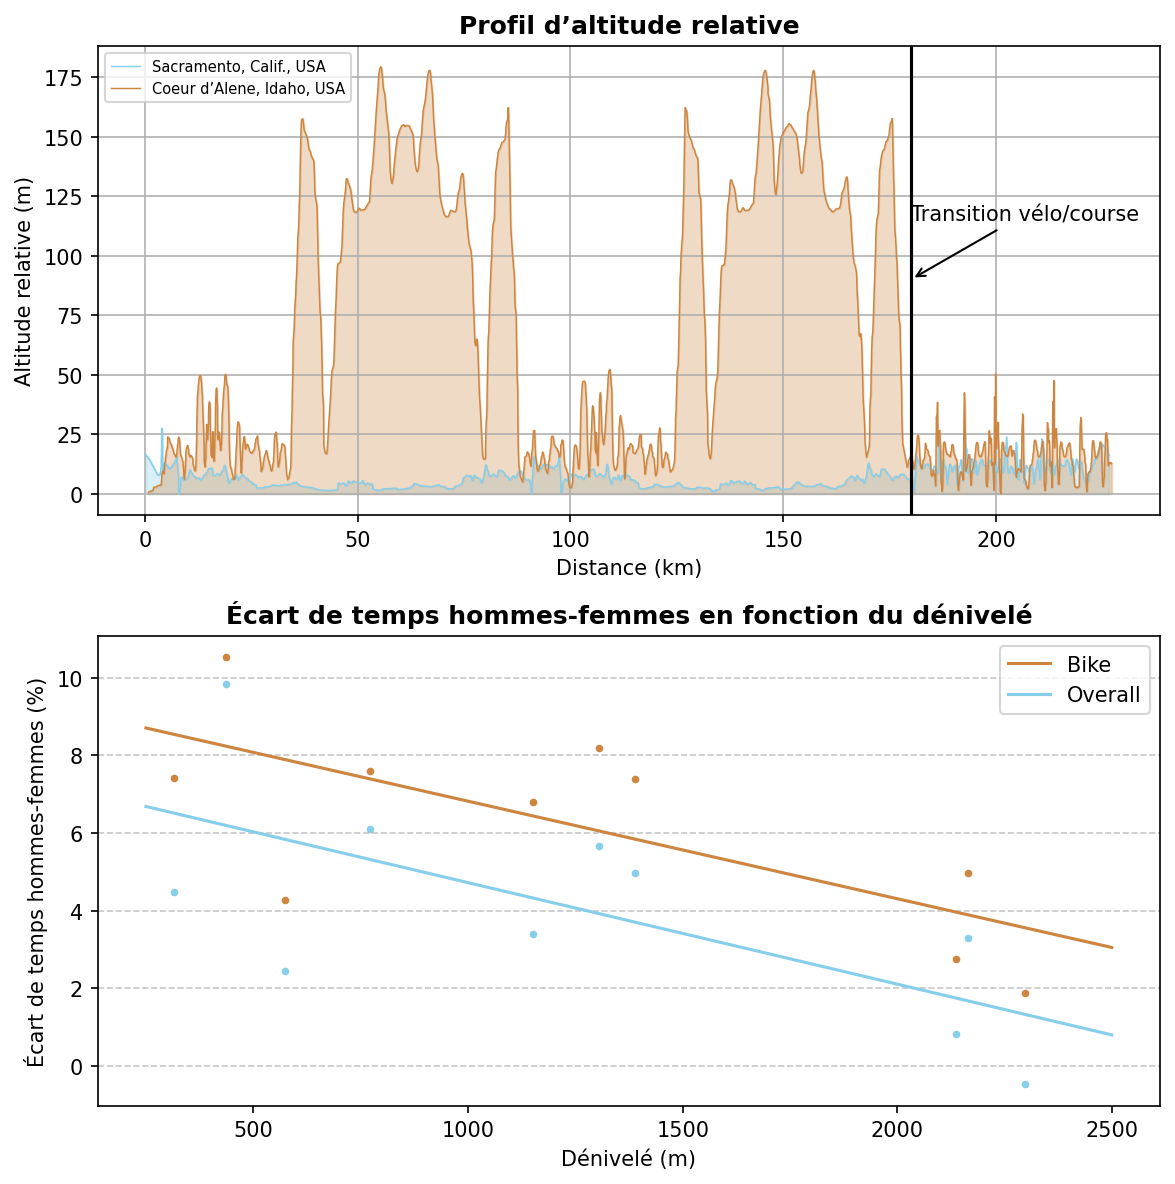

In [27]:
deniv_max = races_info['Location'][races_info['time_sexe_diff'].idxmax()]
deniv_min = races_info['Location'][races_info['time_sexe_diff'].idxmin()]

x_plot = np.arange(250, 2500, 1).reshape(-1, 1)

# Initialisation le modèle de régression linéaire
model_bike = LinearRegression()
model_overall = LinearRegression()

model_bike.fit(np.array(races_info['deniv']).reshape(-1,1), np.array(races_info['bike_time_sexe_diff_perc']).reshape(-1,1))
model_overall.fit(np.array(races_info['deniv']).reshape(-1,1), np.array(races_info['time_sexe_diff_perc']).reshape(-1,1))

y_overall = model_overall.predict(x_plot)
y_bike = model_bike.predict(x_plot)

fig, ax = plt.subplots(2, 1, dpi=150, figsize=(8, 8))  
# Tracé des profils de courses
# Tracé pour deniv_max
ax[0].plot(gpx_data[deniv_max]['Distance'], 
        gpx_data[deniv_max]['filt_alt'] - gpx_data[deniv_max]['filt_alt'].min(), 
        linewidth=0.7, color='skyblue', 
        label = deniv_max )
ax[0].fill_between(gpx_data[deniv_max]['Distance'], 
                gpx_data[deniv_max]['filt_alt'] - gpx_data[deniv_max]['filt_alt'].min(), 
                alpha=0.3, color='skyblue')

# Tracé pour deniv_min
ax[0].plot(gpx_data[deniv_min]['Distance'], 
        gpx_data[deniv_min]['filt_alt'] - gpx_data[deniv_min]['filt_alt'].min(), 
        linewidth=0.7, color='peru',
        label = deniv_min)
ax[0].fill_between(gpx_data[deniv_min]['Distance'], 
                gpx_data[deniv_min]['filt_alt'] - gpx_data[deniv_min]['filt_alt'].min(), 
                alpha=0.3, color='peru')
ax[0].axvline(180, color = 'black')
ax[0].annotate(
    "Transition vélo/course", 
    xy=(180, 90),  
    xytext=(180, 115),     
    arrowprops=dict(facecolor="black", arrowstyle="->"),  
    fontsize=10, 
    color="black"
)


ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Altitude relative (m)')
ax[0].set_title('Profil d’altitude relative',color = 'black', fontweight='bold')
ax[0].legend(fontsize = 7)
ax[0].grid(True)

# Tracé des régressions
ax[1].plot(x_plot, y_bike, color='peru', label='Bike')
ax[1].scatter(races_info['deniv'], races_info['bike_time_sexe_diff_perc'], color='peru', s=7)

ax[1].plot(x_plot, y_overall, color='skyblue', label='Overall')
ax[1].scatter(races_info['deniv'], races_info['time_sexe_diff_perc'], color='skyblue', s=7)

ax[1].set_xlabel("Dénivelé (m)", color="black")
ax[1].set_ylabel("Écart de temps hommes-femmes (%)", color="black")
ax[1].set_title("Écart de temps hommes-femmes en fonction du dénivelé", color="black", fontweight='bold')
ax[1].legend()
ax[1].grid(axis='y', linestyle='--', alpha=0.7)


fig.tight_layout()
fig.savefig('Figures/time_diff_deniv')
plt.show()

2 - Effet de l'humidité sur les écarts hommes/femmes
Encore une fois, la relation entre l'humidité et les écarts hommes/femmes semble linéaire. Une régression linéaire est donc utilisée pour analyser cette relation.

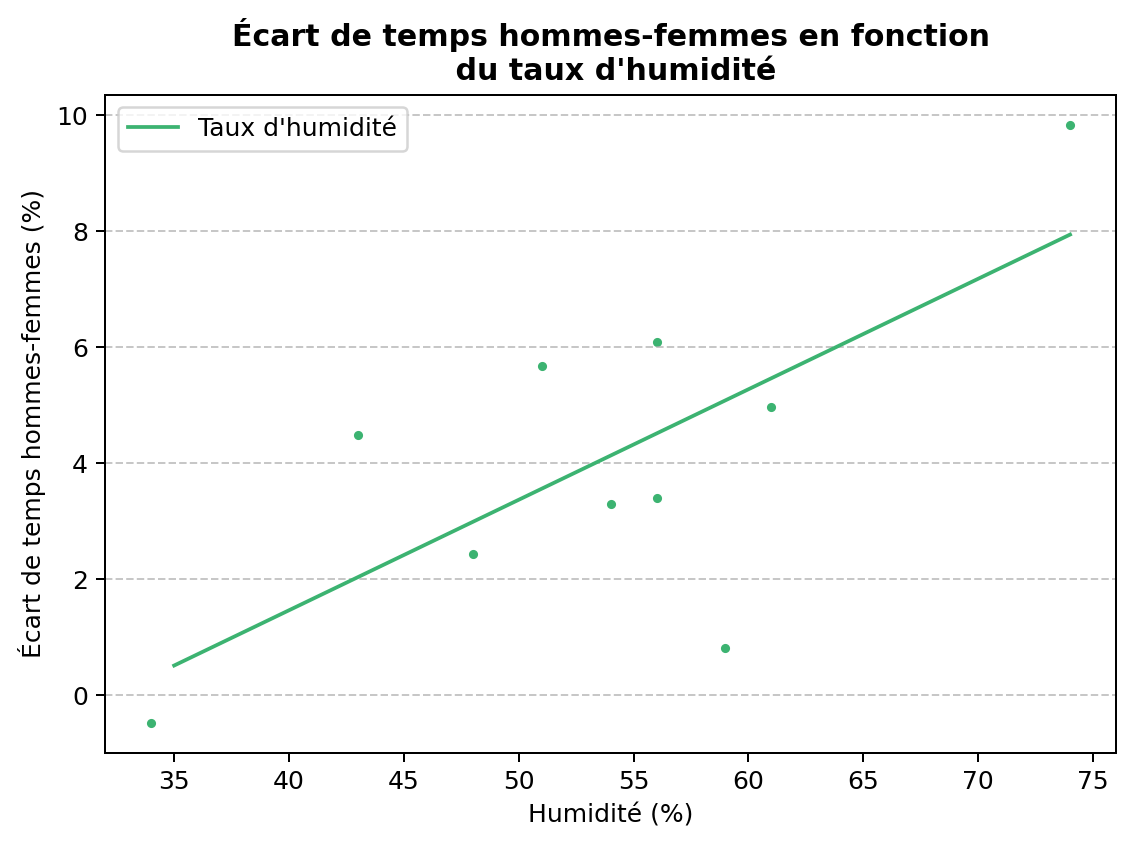

In [28]:
# Écart en fonction de l'humidité

x_plot2 = np.arange(35, 75, 1).reshape(-1, 1)
model_humidity = LinearRegression()
model_humidity.fit(np.array(races_info['humidity_afternoon']).reshape(-1,1), np.array(races_info['time_sexe_diff_perc']).reshape(-1,1))
y_humidity = model_humidity.predict(x_plot2)

fig, ax = plt.subplots(dpi = 180)
ax.plot(x_plot2, y_humidity, color='mediumseagreen', label="Taux d'humidité")
ax.scatter(races_info['humidity_afternoon'], races_info['time_sexe_diff_perc'], color='mediumseagreen', s=7)

ax.set_xlabel("Humidité (%)", color="black")
ax.set_ylabel("Écart de temps hommes-femmes (%)", color="black")
ax.set_title("Écart de temps hommes-femmes en fonction\n du taux d'humidité", color="black", fontweight='bold')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
fig.savefig('Figures/Humidity')

3 - Effet du dénivelé sur le temps total et sur l’écart interquartile du temps total
La relation entre le dénivelé et le temps total semble logarithmique, ce qui conduit à l’utilisation d’une régression logarithmique.

En revanche, la relation entre le dénivelé et l’écart interquartile (IQR) du temps total semble quadratique. Une régression polynomiale d’ordre 2 est donc utilisée pour modéliser cette relation.

Dans tous les cas, davantage de données seraient nécessaires pour valider ces modèles, en particulier pour le modèle quadratique.

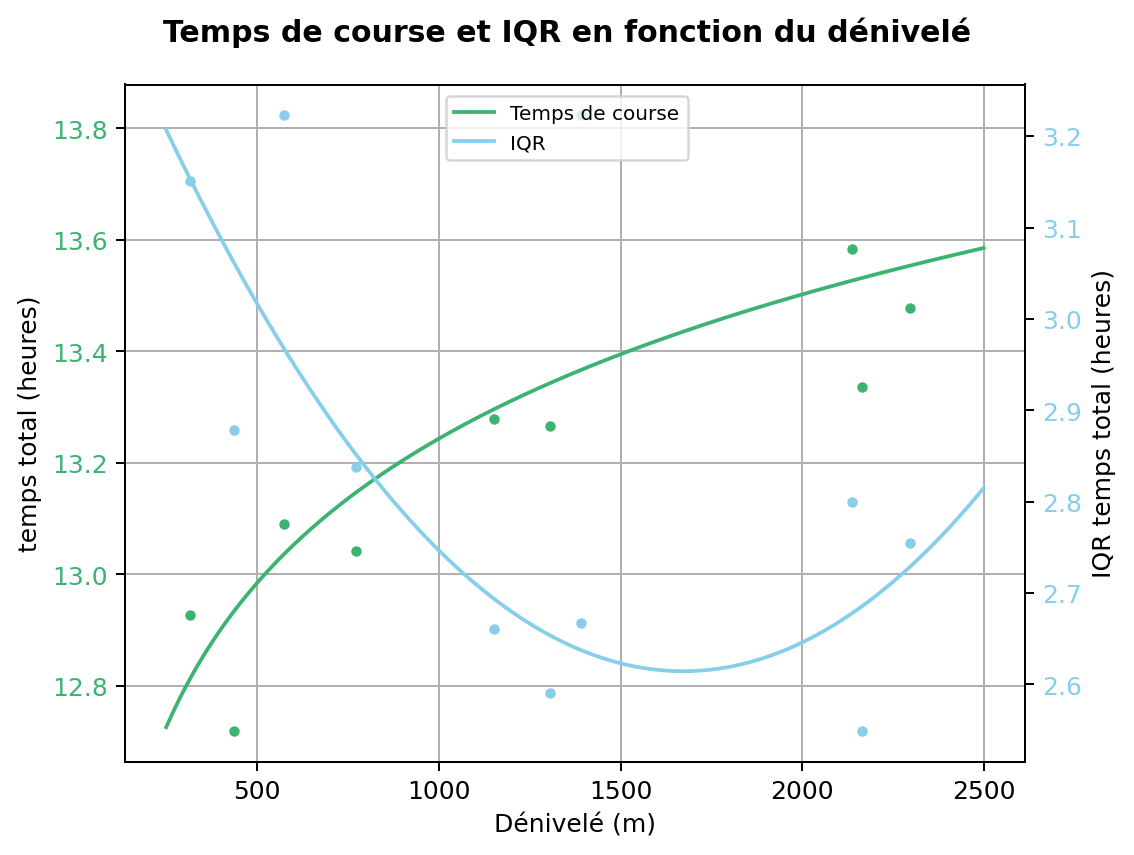

In [31]:

#regression Overrall time
def logmodel(x, a, b):
    return a * np.log(x) + b

X = races_info['deniv'].values.reshape(-1, 1) 
y_ovt = races_info['overall_time'].values 

X_log = np.array(X).ravel()
params, covariance = curve_fit(logmodel, X_log, y_ovt)

# Préparation du plot
x_plot = np.arange(250, 2500, 1).reshape(-1, 1)
y_ovt_new = logmodel(x_plot, *params)

#regression IQR overrall time  
poly = PolynomialFeatures(degree=2) 
model = LinearRegression()
X_poly = poly.fit_transform(X)
x_plot_poly = poly.transform(x_plot)

y_IQR = races_info['IQR overall_time'].values 
model.fit(X_poly, y_IQR)

# Préparation du plot
y_IQR_new = model.predict(x_plot_poly)


fig, ax1 = plt.subplots(dpi=180)

# Premier axe pour 'overall_time'
ax1.scatter(races_info['deniv'], races_info['overall_time'], color='mediumseagreen', s=10)
ax1.set_xlabel('Dénivelé (m)', color='black')
ax1.set_ylabel('temps total (heures)', color='black')
ax1.tick_params(axis='x', labelcolor='black')  
ax1.tick_params(axis='y', labelcolor='mediumseagreen')  
ax1.plot(x_plot, y_ovt_new, color='mediumseagreen', label='Temps de course')
ax1.grid(True)

# plot du second axe
ax2 = ax1.twinx()  
ax2.scatter(races_info['deniv'], races_info['IQR overall_time'], color='skyblue', s=10)
ax2.set_ylabel('IQR temps total (heures)', color='black')
ax2.tick_params(axis='y', labelcolor='skyblue')
ax2.plot(x_plot, y_IQR_new, color='skyblue', label='IQR')

ax1.grid(True)

fig.legend(fontsize=8, loc = 'upper center', bbox_to_anchor=(0.5, 0.9))
fig.suptitle("Temps de course et IQR en fonction du dénivelé", fontweight='bold')  

fig.tight_layout()  
fig.savefig('Figures/IQR_deniv')
plt.show()



On note quand même un outlier pour la courbe de temps en fonction du dénivelé. (il est caché par la légende)

### Sauvegarde du df en csv

In [30]:
races_info.to_csv('races_info.csv')